In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import RandomEffects
import sympy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.regression.mixed_linear_model import MixedLM
import plotly.graph_objects as go
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geoviews
from matplotlib.lines import Line2D
from linearmodels.panel import PanelOLS
from scipy.stats import chi2

raw = pd.read_excel(r"Data\mydata.xlsx", sheet_name="Sheet1")
df=raw[raw['previouscode']>0].copy()
df.reset_index(drop=True, inplace=True)

coord = pd.read_excel(r"Data\coordinates.xlsx")
coord['type'] = 'Moshav'
coord.loc[coord['moshav']==0, 'type'] = 'Kibbutz'
cons_to_omit = coord[(coord['latitude']>32.8) | ((coord['latitude']>32.4) & (coord['longitude']>35.15))]['consumernumber'].unique().tolist()
df = df[~df['consumernumber'].isin(cons_to_omit)].copy()

df['consumertype']='FW'
df.loc[(df['previouscode']>4)&(df['previouscode']<99) , 'consumertype']='FW+S'
df.loc[df['previouscode']>99, 'consumertype']='FW+S+T'

tww_cons = df[df['consumertype']=='FW+S+T']['consumernumber'].unique().tolist()
coord.loc[coord['consumernumber'].isin(tww_cons), 'consumertype'] = 'FW+S+T'

df = df[df['consumernumber']!=7571].copy()


In [2]:
print(df.shape)
df = df[((df['ws']>10) & (df['consumertype']=='FW+S')) | ((df['ws']>10) & (df['consumertype']=='FW+S+T')) | (df['consumertype']=='FW')].copy()
# df = df[df['w1+w2+w3']>20]
df = df[df['w']>50]

print(df.shape)

(1818, 76)
(1620, 76)


In [3]:
print(df.shape)
d = df.groupby(by=['consumernumber'], as_index=False).size().sort_values(by='size', ascending=True)
less_than_3 = d[d['size']<3]['consumernumber'].tolist()
df = df[~df['consumernumber'].isin(less_than_3)].copy()
print(df.shape)
#for mapping
consumers_to_consider = df['consumernumber'].unique().tolist()

(1620, 76)
(1606, 76)


In [4]:
# Define the Haversine function
def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    # lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    d = np.sqrt(dlon**2 + dlat**2)
    km = d * 111.195
    return km

# Coordinates of Tel Aviv
tlv_lat = 32.07570418453909
tlv_lon = 34.79773795332319

coord['distance_from_tlv'] = coord.apply(lambda row: haversine(tlv_lon, tlv_lat, row['longitude'], row['latitude']), axis=1)
dis_df = coord[['consumernumber','distance_from_tlv']].copy()
df = pd.merge(df, dis_df, on='consumernumber', how='left')
df['sqr_distance'] = df['distance_from_tlv']**2


In [ ]:
def map_func1(df,var,title=""):
    min_lng = df['longitude'].min() -0.3
    max_lng = df['longitude'].max() +0.4
    min_lat = df['latitude'].min() -0.7
    max_lat = df['latitude'].max() +0.2
    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
    world = gpd.read_file(r"Data\isr mapping\ne_10m_admin_0_countries_isr.shp")
    fig, ax = plt.subplots(figsize=(12, 8))
    world.plot(ax=ax, column=var, color='whitesmoke', edgecolor='lightgray')
    # Plot 'gdf' with a color map
    l = df[var].unique().tolist()
    # print(l)
    color = {l[0]: 'teal', l[1]: 'darkslateblue'}#, l[2]: 'chocolate'}
    gdf.plot(ax=ax, column=var, color=gdf[var].map(color), legend=True, markersize=20, alpha=0.7)

    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='darkslateblue', markersize=10, label=l[0]),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='teal', markersize=10, label=l[1]),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='chocolate', markersize=10, label=l[2])]
    ax.legend(handles=legend_elements, loc='upper left')

    g1 = df[df[var]=='FW']['consumernumber'].nunique()
    g2 = df[df[var]!='FW']['consumernumber'].nunique()
    g3 = df[df[var]=='FW+S+T']['consumernumber'].nunique()
    
    ax.set_xlim([min_lng, max_lng])  # Set x-axis 
    ax.set_ylim([min_lat, max_lat])    # Set y-axis 
    ax.set_title(f"{g1+g2+g3} total {title}", fontdict={'fontsize': 15}, pad=20)
    # Show plot
    plt.show()

def map_func(df, var, title=""):
    # Calculate map boundaries
    min_lng = df['longitude'].min() - 0.2
    max_lng = df['longitude'].max() + 0.3
    min_lat = df['latitude'].min() - 0.4
    max_lat = df['latitude'].max() + 0.2

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
    world = gpd.read_file(r"Data\isr mapping\ne_10m_admin_0_countries_isr.shp")
    l = df[var].unique().tolist()

    # Group categories into Group 1 and Group 2
    g1 = 'שפירים בלבד'
    g2 = 'שפירים ושפדן'

    gdf['Group'] = gdf[var].apply(lambda x: 'Group 1' if x == l[0] else 'Group 2')

    # Set up color mapping for the two groups
    color = {'Group 1': 'teal', 'Group 2': 'darkslateblue'}

    # Plot world map
    fig, ax = plt.subplots(figsize=(12, 8))
    world.plot(ax=ax, color='whitesmoke', edgecolor='lightgray')

    # Plot grouped data with colors
    gdf.plot(ax=ax, column='Group', color=gdf['Group'].map(color), legend=True, markersize=20, alpha=0.7)

    # Create a legend for the two groups
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='teal', markersize=10, label=g1[::-1]),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='darkslateblue', markersize=10, label=g2[::-1])
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=13)

    # Count unique consumer numbers for each group
    g1 = df[df[var] == l[0]]['consumernumber'].nunique()
    g2 = df[df[var] != l[0]]['consumernumber'].nunique()

    # Adjust plot limits
    ax.set_xlim([min_lng, max_lng])  # Set x-axis
    ax.set_ylim([min_lat, max_lat])  # Set y-axis

    # Add title
    ax.set_title(f"{g1 + g2} total {title}", fontdict={'fontsize': 15}, pad=20)

    # Show the plot
    plt.show()

C:\Users\saarp\AppData\Local\Temp\ipykernel_18808\2457296363.py:59: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gdf.plot(ax=ax, column='Group', color=gdf['Group'].map(color), legend=True, markersize=20, alpha=0.7)


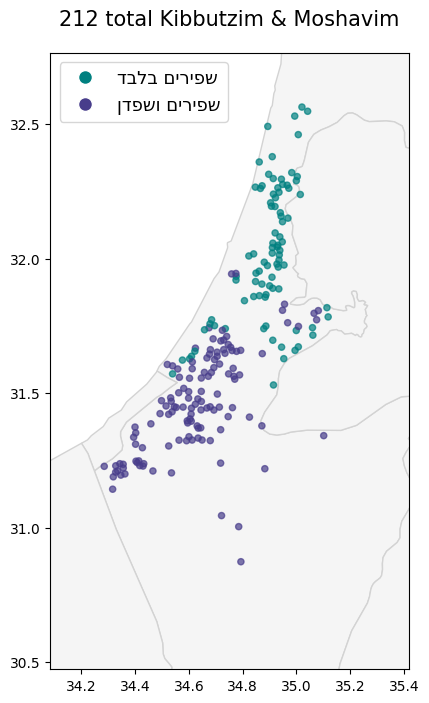

In [6]:
df_map = coord[coord['consumernumber'].isin(consumers_to_consider)].copy()
map_func(df_map,'consumertype',title="Kibbutzim & Moshavim")

#### Data  initial setting

In [7]:
def tarrifs_variables_and_cleaning(df,weight_for_july = 1, shafdan_weight_for_july = 1, type = 'r'):


    nominal_winter_tariff_pf1 = {2015:2.364,2016:2.506,2017:2.506,2018:1.98,2019:2.007,2020:1.841,2021:1.852,2022:1.877}
    nominal_winter_tariff_pf2 = {2015:2.6,2016:2.757,2017:2.757,2018:2.772,2019:3.3,2020:3.294,2021:3.314,2022:3.375}
    nominal_winter_tariff_pf3 = {2015:6.043,2016:5.566,2017:5.385,2018:5.214,2019:5.708,2020:6.09,2021:6.025,2022:4.806}
    nominal_winter_tariff_ps = {2015:1.11,2016:1.094,2017:1.094,2018:1.102,2019:1.116,2020:1.337,2021:1.416,2022:1.448}

    nominal_summer_tariff_pf1 = {2015:2.34,2016:2.5,2017:1.937,2018:1.998,2019:1.94,2020:1.856,2021:1.861,2022:1.94}
    nominal_summer_tariff_pf2 = {2015:2.574,2016:2.75,2017:2.772,2018:2.797,2019:3.3,2020:3.321,2021:3.347,2022:3.489}
    nominal_summer_tariff_pf3 = {2015:5.983,2016:5.553,2017:5.214,2018:5.291,2019:5.708,2020:6.071,2021:4.936,2022:4.886}
    nominal_summer_tariff_ps = {2015:1.099,2016:1.091,2017:1.104,2018:1.112,2019:1.25,2020:1.348,2021:1.43,2022:1.538}

    ## מדד מחירי גידולי השדה - בסיס 2022 המרה שעשיתי לבד 
    tfuka_d = {2022:1,
            2021:0.9846293,
            2020:0.977396,
            2019:0.9566,
            2018:0.964738,
            2017:0.904159,
            2016:0.924566,
            2015:0.865963}
    
    df['p_f1_norm_jul'] = df['year'].map(nominal_summer_tariff_pf1)*df['year'].map(tfuka_d)
    df['p_f2_norm_jul'] = df['year'].map(nominal_summer_tariff_pf2)*df['year'].map(tfuka_d)
    df['p_f3_norm_jul'] = df['year'].map(nominal_summer_tariff_pf3)*df['year'].map(tfuka_d)
    df['p_s_norm_jul'] = df['year'].map(nominal_summer_tariff_ps)*df['year'].map(tfuka_d)

    df['p_f1_norm_jan'] = df['year'].map(nominal_winter_tariff_pf1)*df['year'].map(tfuka_d)
    df['p_f2_norm_jan'] = df['year'].map(nominal_winter_tariff_pf2)*df['year'].map(tfuka_d)
    df['p_f3_norm_jan'] = df['year'].map(nominal_winter_tariff_pf3)*df['year'].map(tfuka_d)
    df['p_s_norm_jan'] = df['year'].map(nominal_winter_tariff_ps)*df['year'].map(tfuka_d)

    df['pf1_num_jul'] = df['year'].map(nominal_summer_tariff_pf1)
    df['pf2_num_jul'] = df['year'].map(nominal_summer_tariff_pf2)
    df['pf3_num_jul'] = df['year'].map(nominal_summer_tariff_pf3)
    df['ps_num_jul'] = df['year'].map(nominal_summer_tariff_ps)

    df['pf1_num_jan'] = df['year'].map(nominal_winter_tariff_pf1)
    df['pf2_num_jan'] = df['year'].map(nominal_winter_tariff_pf2)
    df['pf3_num_jan'] = df['year'].map(nominal_winter_tariff_pf3)
    df['ps_num_jan'] = df['year'].map(nominal_winter_tariff_ps)


    # df['consumertype']='FW'
    # df.loc[df['previouscode']>4 , 'consumertype']='FW+S'
    df['shafdan_access'] = df['indication_var']
    df['tikun'] = np.where(df['year'] > 2017, 1, 0)
    df['tww_access'] = np.where(df['previouscode'] > 99, 1, 0)
    df['tikun_shafdan'] = df['tikun'] * df['shafdan_access']

    df['tikun_qf'] = df['tikun'] * df['q1']
    df['tikun_qs'] = df['tikun'] * df['quota_s']
    df['tikun_Q'] = df['tikun'] * (df['q1']+df['quota_s'])
    df['tikun_qf12'] = df['tikun'] * (df['q1']+df['q2'])

    df['q1/qs'] = df['q1'] / df['quota_s']
    df['nfw_quota'] = df['quota_s'] + df['quota_t']
    df['nfw_q_interact'] = df['quota_s'] * df['quota_t']

    

    df['Preseason Perc (April-May)'] = df['AprilPercp'] + df['MayPercp']
    df['Postseason Perc (September-October)'] = df['SeptemberPercp'] + df['OctoberPercp']
    df['Season Avg Temp (May-Sept)'] = (df['MayTemp'] + df['JuneTemp'] + df['JulyTemp'] + df['AugustTemp'] + df['SeptemberTemp'])/5



    df['shafdan_blended_consumption'] = df['s_consumtion']
    df['shafdan_blended_consumption'] = df['shafdan_blended_consumption'].fillna(0)

    d_trend ={2015:0,2016:1,2017:2,2018:3,2019:4,2020:5,2021:6,2022:7}
    df['trend'] = df['year'].map(d_trend)

    if type == 'r':
        df['pf1'] = df['pf1_jul'] * weight_for_july + df['pf1_jan'] * (1 - weight_for_july)
        df['pf2'] = df['pf2_jul'] * weight_for_july + df['pf2_jan'] * (1 - weight_for_july)
        df['pf3'] = df['pf3_jul'] * weight_for_july + df['pf3_jan'] * (1 - weight_for_july)
        df['ps'] = df['ps_jul'] * shafdan_weight_for_july + df['ps_jan'] * (1 - shafdan_weight_for_july)
        
    elif type == 'n':

        df['pf1'] = df['pf1_num_jul'] * weight_for_july + df['pf1_num_jan'] * (1 - weight_for_july)
        df['pf2'] = df['pf2_num_jul'] * weight_for_july + df['pf2_num_jan'] * (1 - weight_for_july)
        df['pf3'] = df['pf3_num_jul'] * weight_for_july + df['pf3_num_jan'] * (1 - weight_for_july)
        df['ps'] = df['ps_num_jul'] * shafdan_weight_for_july + df['ps_num_jan'] * (1 - shafdan_weight_for_july)

    elif type == 'norm':

        df['pf1'] = df['p_f1_norm_jul'] * weight_for_july + df['p_f1_norm_jan'] * (1 - weight_for_july)
        df['pf2'] = df['p_f2_norm_jul'] * weight_for_july + df['p_f2_norm_jan'] * (1 - weight_for_july)
        df['pf3'] = df['p_f3_norm_jul'] * weight_for_july + df['p_f3_norm_jan'] * (1 - weight_for_july)
        df['ps'] = df['p_s_norm_jul'] * shafdan_weight_for_july + df['p_s_norm_jan'] * (1 - shafdan_weight_for_july)

        
    else:
        print('wrong type')





    df['BSS_tag'] = (df['pf1'] - df['ps']) * df['quota_s']
    df['BS1_tag'] = (df['pf1'] - df['ps']) * df['quota_s'] + (df['pf2'] - df['pf1']) * (df['q1']+df['quota_s'])
    df['BS2_tag'] = (df['pf1'] - df['ps']) * df['quota_s'] + (df['pf2'] - df['pf1']) * (df['q1']+df['quota_s']) + (df['pf3'] - df['pf2']) * (df['quota_s'] + df['q1'] + df['q2'])
    df['delta_BS_tag']= (df['BSS_tag'] - df['BS1_tag']) + (df['BS1_tag'] - df['BS2_tag'])
    df['delta_ps_tag'] = (df['ps'] - df['pf1']) + (df['pf1'] - df['pf2']) + (df['pf2'] - df['pf3'])
    df['delta_ps'] = (df['ps'] - df['pf1'])
    df['delta_pf_tag'] = (df['pf1'] - df['pf2']) + (df['pf2'] - df['pf3'])
    df['delta_pf'] = (df['pf1'] - df['pf2'])
    df['q_delta_pf'] = (df['q1']) * df['delta_pf_tag']
    df['sqr_dps'] = df['delta_ps'] ** 2

    df['q_delta_BS_tag'] = (df['quota_s']) * (df['BSS_tag'] - df['BS1_tag']) + (df['quota_s'] + df['q2']) * (df['BS1_tag'] - df['BS2_tag'])
    df['delta_BS_fw']= (df['BS1_tag'] - df['BS2_tag'])
    df['q_delta_BS_fw'] = (df['q1']) * (df['BS1_tag'] - df['BS2_tag'])

    df['sqr_BS1_tag'] = df['BS1_tag'] ** 2
    df['sqr_BS2_tag'] = df['BS2_tag'] ** 2
    df['sqr_BSS_tag'] = df['BSS_tag'] ** 2
    df['simple(q_delta_BS_tag)'] = (df['quota_s']  + df['q2']) * ((df['BSS_tag'] - df['BS1_tag']) +  (df['BS1_tag'] - df['BS2_tag']))
    df['simple(q_delta_ps)'] = df['delta_ps'] * df['quota_s']
    df['(ps)x(qs)'] = (df['ps']) * df['quota_s']
    df['(ps)xsqr(qs)'] = (df['ps']) * (df['quota_s'] ** 2)

    df['(pf)xsqr(qf)'] = (df['pf1']) * (df['q1'] ** 2)

    df['S x q_delta_BS_fw'] = df['shafdan_access'] * df['q_delta_BS_fw']
    df['S x BS1'] = df['shafdan_access'] * df['BS1_tag']
    df['S x BS2'] = df['shafdan_access'] * df['BS2_tag']
    


    df['FWBS1'] = (df['pf2'] - df['pf1']) * (df['q1'])
    df['FWBS2'] = (df['pf2'] - df['pf1']) * (df['q1']) + (df['pf3'] - df['pf2']) * (df['q1'] + df['q2'])

    df['delta_FWBS'] = (df['FWBS1'] - df['FWBS2'])
    df['S x qdFWBS'] = df['shafdan_access']*df['q1']*df['delta_FWBS']
    df['S x FWBS1'] = df['shafdan_access'] * df['FWBS1']
    df['S x FWBS2'] = df['shafdan_access'] * df['FWBS2']
    df['S x delta_FWBS'] = df['shafdan_access'] * df['delta_FWBS']
    df['sim_q_delta_FWBS'] = (df['q1']) * (df['FWBS1'] - df['FWBS2'])
    df['q_delta_FWBS'] = (df['q1']*df['FWBS1']) - ((df['q1']+df['q2'])*(df['FWBS2']))
    df['S x sim_q_delta_FWBS'] = df['shafdan_access'] * df['sim_q_delta_FWBS']
    df['S x q_delta_FWBS'] = df['shafdan_access'] * df['q_delta_FWBS']

    
    df['nT x FWBS1'] = (1-df['tww_access'])*df['FWBS1']
    df['nT x delta_FWBS'] = (1-df['tww_access']) * df['delta_FWBS']
    df['T x q_delta_BS_fw'] = df['tww_access']*df['q_delta_BS_fw']
    df['T x delta_pf'] = df['tww_access']*df['delta_pf']


    df['nT x BSS_tag'] = (1-df['tww_access'])*df['BSS_tag']
    df['nT x sqr_BS2_tag'] = (1-df['tww_access'])*df['sqr_BS2_tag']
    df['nT x delta_ps'] = (1-df['tww_access'])*df['delta_ps']
    df['nT x q_delta_BS_fw'] = (1-df['tww_access'])*df['q_delta_BS_fw']
    df['nT x sqr_BSS_tag'] = (1-df['tww_access'])*df['sqr_BSS_tag']
    df['nT x q_delta_FWBS'] = (1-df['tww_access'])*df['q_delta_FWBS']
    df['T x sqr_BSS_tag'] = df['tww_access']*df['sqr_BSS_tag']
    df['T x q_delta_FWBS'] = df['tww_access']*df['q_delta_FWBS']
    df['T x delta_ps'] = df['tww_access']*df['delta_ps']
    df['T x BSS_tag'] = df['tww_access']*df['BSS_tag']
    df['T x sqr_BS2_tag'] = df['tww_access']*df['sqr_BS2_tag']
    df['T x BS2_tag'] = df['tww_access']*df['BS2_tag']
    df['Qs x FWBS1'] = df['quota_s'] * df['FWBS1']
    df['Qs x FWBS2'] = df['quota_s'] * df['FWBS2']
    df['Qs x delta_FWBS'] = df['quota_s'] * df['delta_FWBS']   
    df['Qs x qdFWBS'] = df['quota_s']*df['q1']*df['delta_FWBS']
    df['sqr_FWBS2'] = df['FWBS2'] ** 2
    df['q2_FWBS2'] = df['q2'] * df['FWBS2']
    df['q2_dFWBS'] = df['q2'] * df['delta_FWBS']
    df['qs_FWBS2'] = df['quota_s'] * df['FWBS2']
    df['qs_dFWBS'] = df['quota_s'] * df['delta_FWBS']
    df['qs_FWBS1'] = df['quota_s'] * df['FWBS1']
    df['sqr_FWBS1'] = df['FWBS1'] ** 2
    df['q2_FWBS1'] = df['q2'] * df['FWBS1']
    df['q1_dFWBS'] = df['q1'] * df['delta_FWBS']
    df['dpf_dFWBS'] = df['delta_pf'] * df['delta_FWBS']



    df['S x delta_pf_tag'] = df['shafdan_access'] * df['delta_pf_tag']


    df_clean=df[['year', 'consumernumber', 'consumertype','name',
                  'w','w1','w2','w3', 'ws', 'q2', 'pf1', 'pf2', 'pf3', 'w1+w2+w3', 'quota_s','quota_t','q1','ps',
                  'shafdan_access','distance_from_tlv','shafdan_blended_consumption',
                  'Preseason Perc (April-May)','Postseason Perc (September-October)','Season Avg Temp (May-Sept)',
                  'totalvillagesland','tww_access','tikun','trend',

                'delta_FWBS',
                'S x delta_pf_tag',
                'BSS_tag',
                'BS1_tag',
                'BS2_tag',
                'delta_BS_tag',
                'delta_ps_tag',
                'delta_pf_tag',
                'q_delta_BS_tag',
                'sqr_BS1_tag',
                'sqr_BS2_tag',
                'sqr_BSS_tag','delta_pf',
                'simple(q_delta_ps)',
                'simple(q_delta_BS_tag)',
                'delta_BS_fw',
                'q_delta_BS_fw',
                'S x q_delta_BS_fw','nT x delta_FWBS',

                'S x delta_FWBS','S x FWBS1',
                'sim_q_delta_FWBS',
                'q_delta_FWBS','sqr_dps',
                'q_delta_pf','nT x FWBS1','nT x q_delta_FWBS','T x delta_pf','T x q_delta_BS_fw',
                  'S x qdFWBS','FWBS2','sqr_FWBS2', 'q2_FWBS2','q2_dFWBS','qs_FWBS2','qs_dFWBS','S x FWBS2',
                'FWBS1','(ps)x(qs)','(ps)xsqr(qs)','delta_ps','(pf)xsqr(qf)'


                    ]].dropna()

               


    return df_clean

def add_significance_stars(p_value):

    if p_value < 0.01:
        return '***'
    elif p_value < 0.05:
        return '**'
    elif p_value < 0.1:
        return '*'
    else:
        return ''
    
def Descriptives(df):
    X_vars = ['quota_s', 'q1','Preseason Perc (April-May)','Postseason Perc (September-October)','Season Avg Temp (May-Sept)','quota_t','tww_access','tikun','totalvillagesland']

    stat_df = df[['consumernumber','consumertype', 'year','w', 'w1', 'w2', 'w3', 'ws','q2','pf1','pf2','pf3','ps','w1+w2+w3'] + X_vars].dropna()
    fw_data = stat_df[stat_df['consumertype'] == 'FW']
    s_data = stat_df[stat_df['consumertype'] != 'FW']
    # t_data = stat_df[stat_df['consumertype'] == 'FW+S+T']

    print(f"{fw_data['consumernumber'].nunique()} FW consumers")
    print(f"{s_data['consumernumber'].nunique()} FW+S consumers")
    # print(f"{t_data['consumernumber'].nunique()} FW+S+T consumers")
    print(f"{stat_df['consumernumber'].nunique()} total consumers")
    # both_groups = np.intersect1d(s_data['consumernumber'].unique(), fw_data['consumernumber'].unique(), t_data['consumernumber'].unique())
    # d = {row['consumernumber']: row['name'] for _, row in df.iterrows()}

    # print(f"{len(both_groups)} consumers in both groups")
    # print(f"These are the consumers in both groups:")
    # for con in both_groups:
    #     print(f"{con} {d[con]}")

    varlist = ['w','q1', 'w1+w2+w3','w1', 'w2', 'w3','quota_s',  'ws','Season Avg Temp (May-Sept)',
     'Preseason Perc (April-May)','Postseason Perc (September-October)','totalvillagesland','tww_access','quota_t','ps','pf1','pf2','pf3']


    fw_data1 = fw_data[varlist].agg(['mean', 'std','min','max']).T
    s_data1 = s_data[varlist].agg(['mean', 'std','min','max']).T
    # t_data1 = t_data[varlist].agg(['mean', 'std']).T

    comparison_df = fw_data1.join(s_data1, lsuffix=' Fw', rsuffix=' Shafdan')
    # comparison_df = comparison_df.join(t_data1, rsuffix=' TWW')
    comparison_df = comparison_df.round(2)

    comparison_df.rename(index={'w': 'Total Consumption', 'w1+w2+w3': 'FW Consumption', 'ws': 'Shafdan Consumption',
                                'quota_s':'Shafdan Qouta','q1':'FW Initial Qouta',
                                'qf1_per_dunam':'fw qouta per dunam','Preseason_Perc (mar-jul)':'Pre-season Percipitation (Mar-July)',
                                'Season_Perc (aug-oct)': 'Season Percipitation (Aug-Oct)',
                                'Preseason_Temp (May-July)': 'Pre-season Avg Temp (May-July)',
                                'qs_per_dunam':'shafdan qouta per dunam','quota_t':'Other NFW Quota','tww_access':'Other NFW Access',
                                'tikun':'Tikun27'
                                }, inplace=True)
    return comparison_df

def Descriptives2(df):

    X_vars = ['quota_s', 'q1','ps']

    stat_df = df[['consumernumber','consumertype', 'year','w', 'w1', 'w2', 'w3', 'ws','q2','pf1','pf2','pf3','w1+w2+w3'] + X_vars ].dropna()


    # Filter for necessary data and count observations per year and consumertype
    observation_counts = stat_df.groupby(['year', 'consumertype']).size().unstack(fill_value=0)
    # Ensure all years from 2015 to 2022 are included
    all_years = pd.DataFrame(index=range(2015, 2023))
    observation_counts = all_years.join(observation_counts, how='left').fillna(0).astype(int)
    # Rename columns for clarity
    observation_counts.columns = ['FW Accsess', 'FW and Shafdan Accsess', 'FW and Shafdan and Tww']

        # Transpose the table
    observation_counts_table_transposed = observation_counts.T

    # Add a "Total" column to sum up each group's observations across all years
    observation_counts_table_transposed['Total Observations'] = observation_counts_table_transposed.sum(axis=1)


    return observation_counts_table_transposed

def manual_prediction(row, coefficients, fe_effect=0):
    # Start with the constant term
    pred = coefficients.get('const', 0)
    
    # Add contributions from other variables
    pred += (row[coefficients.index.difference(['const'])] * coefficients.drop('const')).sum()
    
    return pred

def hausman_test(fe_model, re_model):
    fe_params = fe_model.params
    re_params = re_model.params

    diff = fe_params - re_params
    
    cov_fe = fe_model.cov
    cov_re = re_model.cov
    cov_diff = cov_fe - cov_re
    
    test_statistic = np.abs(diff.T @ np.linalg.inv(cov_diff) @ diff)
    
    df = len(diff)
    
    p_value = 1 - chi2.cdf(test_statistic, df)
    
    return test_statistic, p_value

def calculate_aic_bic_approx(model_results, n_obs):
    """
    Calculate an approximate AIC and BIC for a model based on RSS and number of observations.
    
    Parameters:
    - model_results: The model result object with `params` and `resids` attributes.
    - n_obs: The number of observations in the model.
    
    Returns:
    - AIC: The Akaike Information Criterion.
    - BIC: The Bayesian Information Criterion.
    """
    n_params = model_results.params.shape[0]  # number of parameters
    rss = np.sum(model_results.resids ** 2)  # residual sum of squares
    sigma_squared = rss / n_obs
    # Approximate log-likelihood from RSS
    log_likelihood_approx = -0.5 * n_obs * (np.log(2 * np.pi) + np.log(sigma_squared) + 1)

    # Calculate AIC and BIC based on this approximate log-likelihood
    AIC = -2 * log_likelihood_approx + 2 * n_params
    BIC = -2 * log_likelihood_approx + np.log(n_obs) * n_params
    return AIC, BIC

def min_top5(df, var = 'totalvillagesland', var_name = 'Area (dunam)'):
    if var == 'totalvillagesland':
        df = df[df['year']==2015].copy()
    elif var ==  'Postseason Perc (September-October)' or var == 'Preseason Perc (April-May)':
        df = df.copy()
    else:
        df = df[['consumertype', 'name',var]].groupby(['consumertype','name'], as_index=False)[var].mean(numeric_only=True).round(1)

    if var !=  'Postseason Perc (September-October)' and var != 'Preseason Perc (April-May)':
        min_fw_s = df[df['consumertype'] == 'FW+S'].nsmallest(5, var)[['name', 'consumertype', var]]
        if var != 'ws' and var != 'quota_s' and var != 'quota_t':
            min_fw = df[df['consumertype'] == 'FW'].nsmallest(5, var)[['name', 'consumertype', var]]
            df_min = pd.concat([min_fw_s, min_fw], axis=0)
        else:
            df_min = min_fw_s.copy()

        df_min = df_min[['consumertype', 'name',var]].rename(columns={'name':'Name',
                                                                        var:var_name,
                                                                        'consumertype':'Access Type'}).sort_values(by=['Access Type',var_name], ascending=False).reset_index(drop=True)
        df_min[var_name] = df_min[var_name].round(1)

    
    else:
        min_fw_s = df[df['consumertype'] == 'FW+S'].nsmallest(5, var)[['year','name', 'consumertype', var]]
        min_fw = df[df['consumertype'] == 'FW'].nsmallest(5, var)[['year','name', 'consumertype', var]]

        df_min = pd.concat([min_fw_s, min_fw], axis=0)
        df_min = df_min[['year','consumertype', 'name',var]].rename(columns={'name':'Name',
                                                                        var:var_name,
                                                                        'consumertype':'Access Type'}).sort_values(by=['Access Type',var_name], ascending=False).reset_index(drop=True)


        df_min[var_name] = df_min[var_name].round(2)
    return df_min

def max_top5(df, var = 'totalvillagesland', var_name = 'Area (dunam)'):
    if var == 'totalvillagesland':
        df = df[df['year']==2015].copy()
    elif var ==  'Postseason Perc (September-October)' or var == 'Preseason Perc (April-May)':
        df = df.copy()
    else:
        df = df[['consumertype', 'name',var]].groupby(['consumertype','name'], as_index=False)[var].mean(numeric_only=True).round(1)

    if var !=  'Postseason Perc (September-October)' and var != 'Preseason Perc (April-May)':
        max_fw_s = df[df['consumertype'] == 'FW+S'].nlargest(5, var)[['name', 'consumertype', var]]
        if var != 'ws' and var != 'quota_s' and var != 'quota_t':
            max_fw = df[df['consumertype'] == 'FW'].nlargest(5, var)[['name', 'consumertype', var]]
            df_max = pd.concat([max_fw_s, max_fw], axis=0)
        else:
            df_max = max_fw_s.copy()

        df_max = df_max[['consumertype', 'name',var]].rename(columns={'name':'Name',
                                                                        var:var_name,
                                                                        'consumertype':'Access Type'}).sort_values(by=['Access Type',var_name], ascending=False).reset_index(drop=True)
        df_max[var_name] = df_max[var_name].round(1)

    
    else:
        max_fw_s = df[df['consumertype'] == 'FW+S'].nlargest(5, var)[['year','name', 'consumertype', var]]
        max_fw = df[df['consumertype'] == 'FW'].nlargest(5, var)[['year','name', 'consumertype', var]]

        df_max = pd.concat([max_fw_s, max_fw], axis=0)
        df_max = df_max[['year','consumertype', 'name',var]].rename(columns={'name':'Name',
                                                                        var:var_name,
                                                                        'consumertype':'Access Type'}).sort_values(by=['Access Type',var_name], ascending=False).reset_index(drop=True)


        df_max[var_name] = df_max[var_name].round(2)

    
    return df_max

#### Summary statistic - drill down tables

In [8]:
mydata = tarrifs_variables_and_cleaning(df,0.5,0.5, "norm")
Minimization_method = 'CV'
Descriptives(mydata)

87 FW consumers
128 FW+S consumers
211 total consumers


C:\Users\saarp\AppData\Local\Temp\ipykernel_18808\235632250.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['qs_FWBS2'] = df['quota_s'] * df['FWBS2']
C:\Users\saarp\AppData\Local\Temp\ipykernel_18808\235632250.py:174: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['qs_dFWBS'] = df['quota_s'] * df['delta_FWBS']
C:\Users\saarp\AppData\Local\Temp\ipykernel_18808\235632250.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

,mean Fw,std Fw,min Fw,max Fw,mean Shafdan,std Shafdan,min Shafdan,max Shafdan
Total Consumption,471.27,360.64,50.24,1960.24,1439.73,945.72,74.83,4886.07
FW Initial Qouta,598.21,410.29,43.24,2274.62,727.20,545.20,3.26,2945.23
FW Consumption,471.27,360.64,50.24,1960.24,504.98,447.37,1.13,2365.37
w1,453.53,353.88,43.24,1960.24,470.80,419.16,1.13,2350.40
w2,7.20,20.77,0.00,195.51,13.61,43.93,0.00,401.49
w3,10.54,64.00,0.00,637.65,20.57,82.32,0.00,973.95
Shafdan Qouta,0.00,0.00,0.00,0.00,980.28,682.67,25.00,3194.30
Shafdan Consumption,0.00,0.00,0.00,0.00,934.75,696.53,11.09,3194.30
Season Avg Temp (May-Sept),26.00,0.21,24.43,26.33,26.13,0.20,25.28,26.78
Preseason Perc (April-May),22.32,16.56,0.83,68.78,17.58,12.86,0.23,54.00


In [9]:
Descriptives2(mydata)

,2015,2016,2017,2018,2019,2020,2021,2022,Total Observations
FW Accsess,79,81,82,81,76,72,74,71,616
FW and Shafdan Accsess,78,79,84,82,79,75,77,73,627
FW and Shafdan and Tww,40,40,39,41,43,43,39,39,324


In [9]:
# mydata[(mydata['consumertype']=='FW+S') & (mydata['tww_access']==1)][['quota_t','quota_s']].plot(kind='scatter', x='quota_t', y='quota_s')
# mydata[(mydata['consumertype']=='FW+S') & (mydata['quota_t']>800)][['year','name','consumernumber','w','w1','ws','q1','quota_s','quota_t']].sort_values(by='quota_t', ascending=False).head()

##### Tables

In [11]:
mydata['consumertype2'] = 'FW'
mydata.loc[mydata['consumertype']!='FW+S', 'consumertype2'] = 'FW+S'
wf_std = mydata.groupby(by=['consumertype2','consumernumber'],as_index=False)['w1+w2+w3'].std().rename(columns={'w1+w2+w3':'wf_std'})
qf_std = mydata.groupby(by=['consumertype2','consumernumber'],as_index=False)['q1'].std().rename(columns={'q1':'qf_std'})

wf_std = wf_std.merge(qf_std, on=['consumertype2','consumernumber'], how='left')

In [12]:
mydata['consumertype2']
mydata.groupby('consumertype2')['consumernumber'].nunique()

consumertype2
FW       89
FW+S    137
Name: consumernumber, dtype: int64

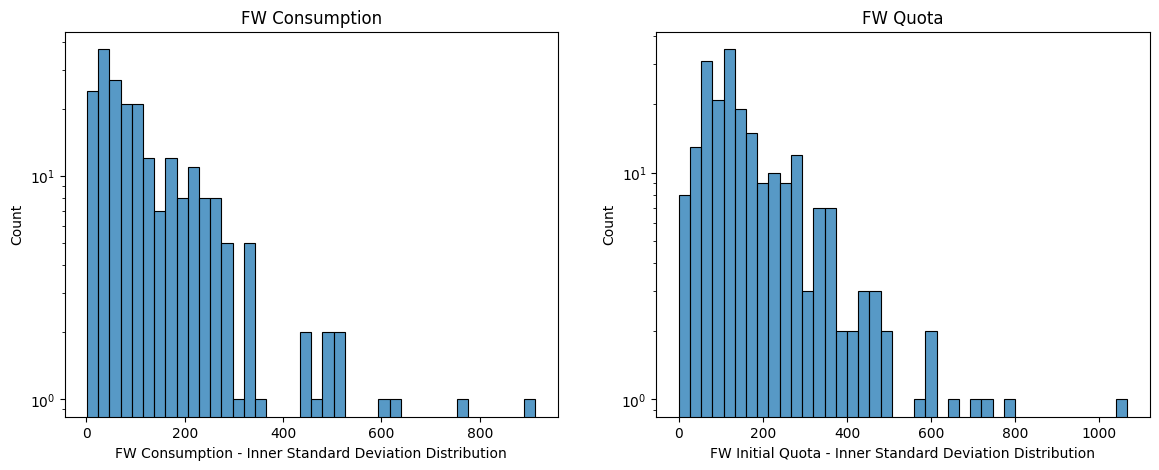

In [13]:
fig, ax = plt.subplots(1,2,figsize=(14, 5))
sns.histplot(data=wf_std,x='wf_std',bins = 40, ax=ax[0])#,hue='consumertype2'), log_scale=True
ax[0].set_title('FW Consumption')
ax[0].set_xlabel("FW Consumption - Inner Standard Deviation Distribution")
# ax[0].legend(title='Consumer Type', loc='upper left', labels=['FW+S access', 'FW access'])
ax[0].set_yscale('log')
sns.histplot(data=wf_std,x='qf_std',bins = 40, ax=ax[1])#,hue='consumertype2', log_scale=True
ax[1].set_title('FW Quota')
ax[1].set_xlabel("FW Initial Quota - Inner Standard Deviation Distribution")
# ax[1].legend(title='Consumer Type', loc='upper left', labels=['FW+S access', 'FW access'])
ax[1].set_yscale('log')

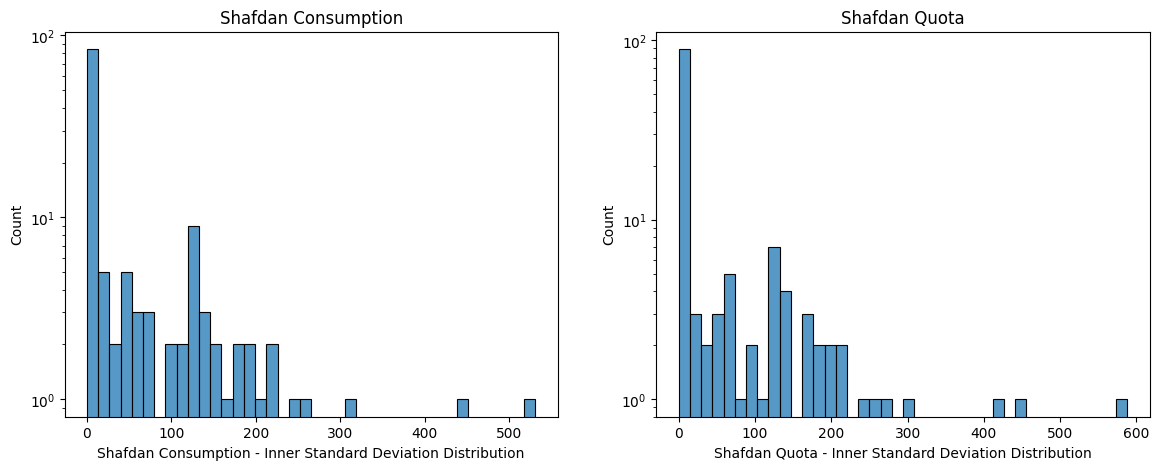

In [14]:
ws_std = mydata[mydata['consumertype2']=='FW+S'].groupby(by=['consumernumber'],as_index=False)['ws'].std().rename(columns={'ws':'ws_std'})
qs_std = mydata[mydata['consumertype2']=='FW+S'].groupby(by=['consumernumber'],as_index=False)['quota_s'].std().rename(columns={'quota_s':'qs_std'})

ws_std = ws_std.merge(qs_std, on=['consumernumber'], how='left')

fig, ax = plt.subplots(1,2,figsize=(14, 5))
sns.histplot(data=ws_std,x='ws_std',bins = 40, ax=ax[0])#,hue='consumertype2'), log_scale=True
ax[0].set_title('Shafdan Consumption')
ax[0].set_xlabel("Shafdan Consumption - Inner Standard Deviation Distribution")
ax[0].set_yscale('log')
# ax[0].legend(title='Consumer Type', loc='upper left', labels=['FW+S access', 'FW access'])
sns.histplot(data=ws_std,x='qs_std',bins = 40, ax=ax[1])#,hue='consumertype2', log_scale=True
ax[1].set_title('Shafdan Quota')
ax[1].set_xlabel("Shafdan Quota - Inner Standard Deviation Distribution")
# ax[1].legend(title='Consumer Type', loc='upper left', labels=['FW+S access', 'FW access'])
ax[1].set_yscale('log')


In [26]:
wf_std = mydata.groupby(by=['consumertype2','consumernumber'],as_index=False)['w1+w2+w3'].std().rename(columns={'w1+w2+w3':'std'})
wf_std['type'] = 'Consumption'
qf_std = mydata.groupby(by=['consumertype2','consumernumber'],as_index=False)['q1'].std().rename(columns={'q1':'std'})
qf_std['type'] = 'Quota'

wf_std = pd.concat([wf_std, qf_std], axis=0).reset_index(drop=True)

ws_std = mydata[mydata['consumertype2']=='FW+S'].groupby(by=['consumernumber'],as_index=False)['ws'].std().rename(columns={'ws':'std'})
ws_std['type'] = 'Consumption'
qs_std = mydata[mydata['consumertype2']=='FW+S'].groupby(by=['consumernumber'],as_index=False)['quota_s'].std().rename(columns={'quota_s':'std'})
qs_std['type'] = 'Quota'

ws_std = pd.concat([ws_std, qs_std], axis=0).reset_index(drop=True)



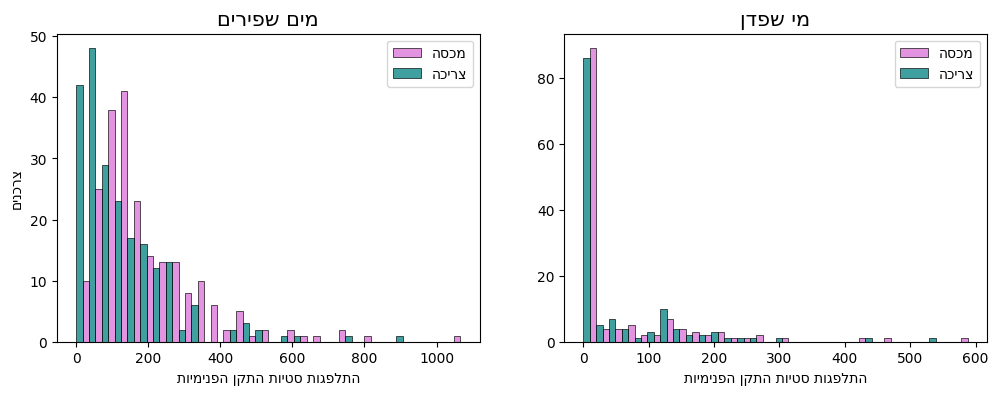

In [59]:
palette = ['teal', 'orchid']

quota_1 = 'מכסה'
consumption_1 = 'צריכה'
fw_1 = 'מים שפירים'
s_1 = 'מי שפדן'
inner_1 = 'התלפגות סטיות התקן הפנימיות'
c_1 = "צרכנים"


fig, ax = plt.subplots(1,2,figsize=(12, 4))
sns.histplot(data=wf_std,x='std',hue='type',bins = 30, ax=ax[0], multiple='dodge', palette=palette)
ax[0].set_title(fw_1[::-1], fontsize=15)
ax[0].set_xlabel(inner_1[::-1])
ax[0].set_ylabel(c_1[::-1])
# ax[0].set_yscale('log')
ax[0].legend(loc='upper right', labels=[quota_1[::-1],consumption_1[::-1]])
sns.histplot(data=ws_std,x='std',hue='type',bins = 30, ax=ax[1], multiple='dodge', palette=palette)

ax[1].set_title(s_1[::-1], fontsize=15)
ax[1].set_xlabel(inner_1[::-1])
ax[1].set_ylabel("")
# ax[1].set_yscale('log')
ax[1].legend(loc='upper right', labels=[quota_1[::-1],consumption_1[::-1]])



In [164]:
mydata_s = mydata[mydata['consumertype'] != 'FW']
mydata_s['Cought_in_qs'] = np.where(mydata_s['ws'] == mydata_s['quota_s'], '[Vmps > ps]', '[Vmps = ps]')
mydata_s['Cought_in_qf'] = np.where(mydata_s['w1+w2+w3'] < mydata_s['q1'], '[Vmpf = pf1]',
                                    np.where(mydata_s['w1+w2+w3'] < mydata_s['q1']+mydata_s['q2'], '[Vmpf = pf2]', '[Vmpf = pf3]'))

pd.crosstab(mydata_s['Cought_in_qs'], mydata_s['Cought_in_qf'], margins=True, margins_name='Total')

C:\Users\saarp\AppData\Local\Temp\ipykernel_15060\1529132696.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata_s['Cought_in_qs'] = np.where(mydata_s['ws'] == mydata_s['quota_s'], '[Vmps > ps]', '[Vmps = ps]')
C:\Users\saarp\AppData\Local\Temp\ipykernel_15060\1529132696.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata_s['Cought_in_qf'] = np.where(mydata_s['w1+w2+w3'] < mydata_s['q1'], '[Vmpf = pf1]',


Cought_in_qf,[Vmpf = pf1],[Vmpf = pf2],[Vmpf = pf3],Total
Cought_in_qs,,,,
[Vmps = ps],316,16,10,342
[Vmps > ps],439,57,120,616
Total,755,73,130,958


In [78]:
# max_top5(mydata, var = 'totalvillagesland', var_name = 'Area (dunam)')
# max_top5(mydata, var = 'Preseason Perc (April-May)', var_name = 'Preseason Percipitation (mm)')
max_top5(mydata[mydata['year']==2018], var = 'Postseason Perc (September-October)', var_name = 'Postseason Percipitation (mm)')
# max_top5(mydata, var = 'Season Avg Temp (May-Sept)', var_name = 'Season Avg Temp (C)')
# max_top5(mydata, var = 'ws', var_name = 'Mean Shafan Consumption (1000m³)')
# max_top5(mydata, var = 'q1', var_name = 'Mean Initial Quota (1000m³)')
# max_top5(mydata, var = 'quota_s', var_name = 'Mean Shafdan Quota (1000m³)')
# max_top5(mydata, var = 'w', var_name = 'Mean Total Consumption (1000m³)')
# max_top5(mydata, var = 'w1+w2+w3', var_name = 'Mean FW Consumption (1000m³)')
# max_top5(mydata, var = 'quota_t', var_name = 'Mean TWW Quota (1000m³)')

,year,Access Type,Name,Postseason Percipitation (mm)
0,2018,FW+S,DOROT,56.71
1,2018,FW+S,NIR MOSHE,33.44
2,2018,FW+S,NIR AQIVA,32.78
3,2018,FW+S,GEVIM,29.70
4,2018,FW+S,ZERU'A,29.38
5,2018,FW,ZOVA,27.75
6,2018,FW,ZANOAH,27.72
7,2018,FW,OZEM,27.23
8,2018,FW,AGUR,25.62
9,2018,FW,GIV'AT YESHA'YAHU,25.61


In [87]:
# min_top5(mydata, var = 'totalvillagesland', var_name = 'Area (dunam)')
# min_top5(mydata, var = 'Preseason Perc (April-May)', var_name = 'Preseason Percipitation (mm)')
min_top5(mydata[mydata['year']==2018], var = 'Postseason Perc (September-October)', var_name = 'Postseason Percipitation (mm)')
# min_top5(mydata, var = 'Season Avg Temp (May-Sept)', var_name = 'Season Avg Temp (C)')
# min_top5(mydata, var = 'ws', var_name = 'Mean Shafan Consumption (1000m³)')
# min_top5(mydata, var = 'q1', var_name = 'Mean Initial Quota (1000m³)')
# min_top5(mydata, var = 'quota_s', var_name = 'Mean Shafdan Quota (1000m³)')
# min_top5(mydata, var = 'w', var_name = 'Mean Total Consumption (1000m³)')
# min_top5(mydata, var = 'w1+w2+w3', var_name = 'Mean FW Consumption (1000m³)')

,year,Access Type,Name,Postseason Percipitation (mm)
0,2018,FW+S,SEDE NIZZAN,18.03
1,2018,FW+S,NIR YIZHAQ,17.89
2,2018,FW+S,MIVTAHIM,17.12
3,2018,FW+S,AMMI'OZ,17.10
4,2018,FW+S,YESHA,16.51
5,2018,FW,GIV'AT NILI,22.70
6,2018,FW,AVI'EL,22.45
7,2018,FW,HAVAZZELET HASHARON,22.31
8,2018,FW,ELYASHIV,20.45
9,2018,FW,SEDOT YAM,19.70


In [10]:
# mydata.groupby(['year', 'consumertype'])['Preseason Perc (April-May)'].mean().unstack()

In [11]:
# mydata['Postseason Perc (September-October)'].mean()
# mydata.groupby(['year', 'consumertype'])['Postseason Perc (September-October)'].mean().unstack()

In [65]:
# Execute the function
Descriptives2(mydata)

,2015,2016,2017,2018,2019,2020,2021,2022,Total Observations
FW Accsess,79,81,82,81,76,72,74,71,616
FW and Shafdan Accsess,78,79,84,82,79,75,77,73,627
FW and Shafdan and Tww,40,41,40,42,44,44,40,40,331


##### Graphs

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'AVIGEDOR'),
  Text(1, 0, 'BEROSH'),
  Text(2, 0, "TE'ASHUR"),
  Text(3, 0, 'SUFA'),
  Text(4, 0, "MAVQI'IM"),
  Text(5, 0, 'ZOHAR'),
  Text(6, 0, 'MASLUL'),
  Text(7, 0, 'PATTISH'),
  Text(8, 0, 'TALME BILU'),
  Text(9, 0, 'TIFRAH'),
  Text(10, 0, 'SHUVA'),
  Text(11, 0, 'EREZ'),
  Text(12, 0, 'QOMEMIYYUT'),
  Text(13, 0, 'REWAHA'),
  Text(14, 0, 'SHALWA')])

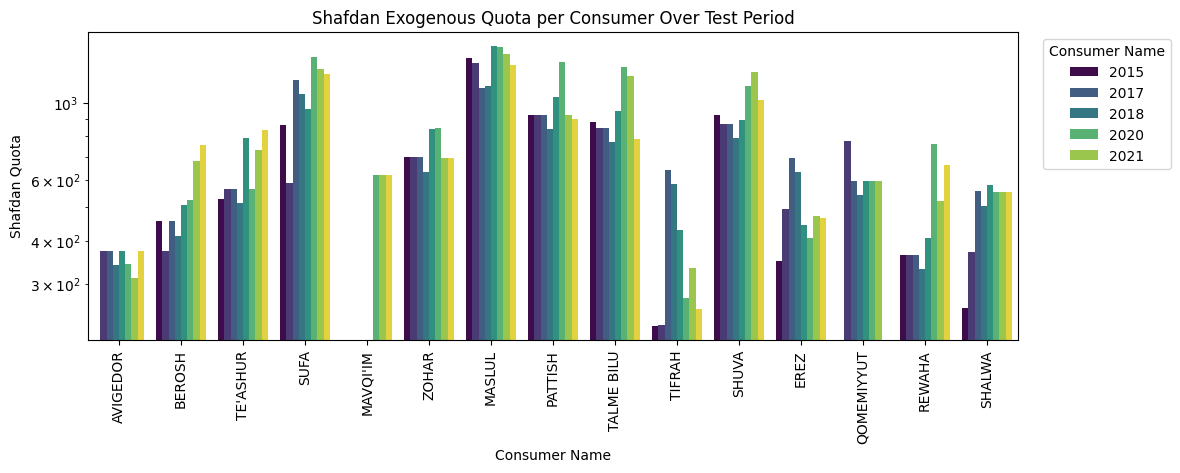

In [40]:
import random

exog_quotas_test = mydata[mydata['consumertype']!='FW'][['name','year','quota_s','q1']]

rand_10cons = random.sample(list(exog_quotas_test['name'].unique()), 15)
exog_quotas_test = exog_quotas_test[exog_quotas_test['name'].isin(rand_10cons)].copy()

plt.subplots(figsize=(12, 4))
sns.barplot(x='name', y='quota_s', hue='year', data=exog_quotas_test, palette='viridis')
plt.title('Shafdan Exogenous Quota per Consumer Over Test Period')
plt.yscale('log')
plt.xlabel('Consumer Name')
plt.ylabel('Shafdan Quota')
plt.legend(title='Consumer Name', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'GAN SOREQ'),
  Text(1, 0, "NETA'IM"),
  Text(2, 0, 'TIDHAR'),
  Text(3, 0, 'OHAD'),
  Text(4, 0, 'EN HASHELOSHA'),
  Text(5, 0, 'HOLIT'),
  Text(6, 0, "GE'A"),
  Text(7, 0, "GEVAR'AM"),
  Text(8, 0, 'KARMIYYA'),
  Text(9, 0, 'GILAT'),
  Text(10, 0, 'NIR MOSHE'),
  Text(11, 0, 'ALUMIM'),
  Text(12, 0, "MASH'ABBE SADE"),
  Text(13, 0, 'BEROR HAYIL'),
  Text(14, 0, 'UZA')])

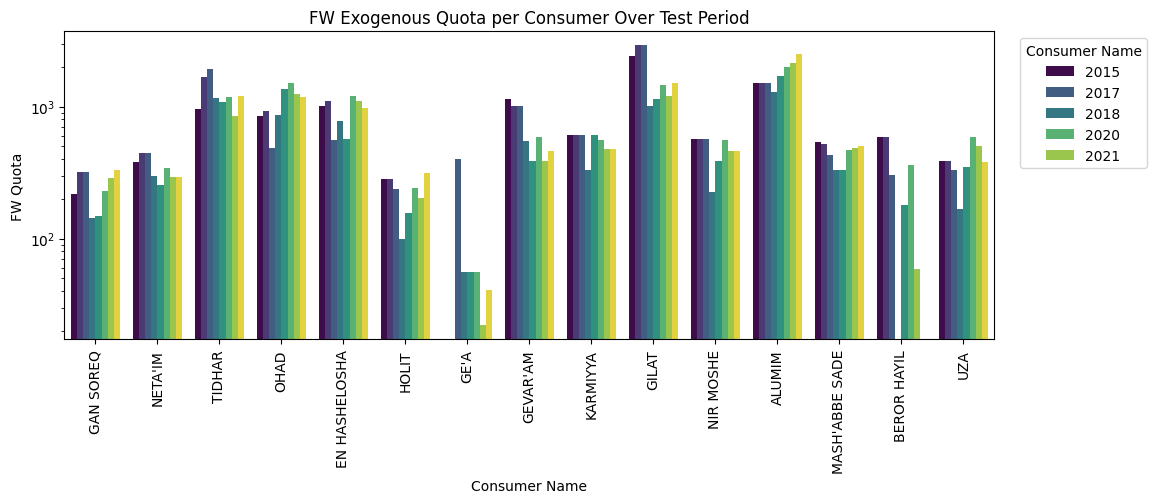

In [42]:
exog_quotas_test = mydata[mydata['consumertype']!='FW'][['name','year','quota_s','q1']]

rand_10cons = random.sample(list(exog_quotas_test['name'].unique()), 15)
exog_quotas_test = exog_quotas_test[exog_quotas_test['name'].isin(rand_10cons)].copy()

plt.subplots(figsize=(12, 4))
sns.barplot(x='name', y='q1', hue='year', data=exog_quotas_test, palette='viridis')
plt.title('FW Exogenous Quota per Consumer Over Test Period')
plt.yscale('log')
plt.xlabel('Consumer Name')
plt.ylabel('FW Quota')
plt.legend(title='Consumer Name', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=90)

<Axes: title={'center': 'Shafdan and TWW Quotas'}, xlabel='TWW Quota', ylabel='Shafdan Quota'>

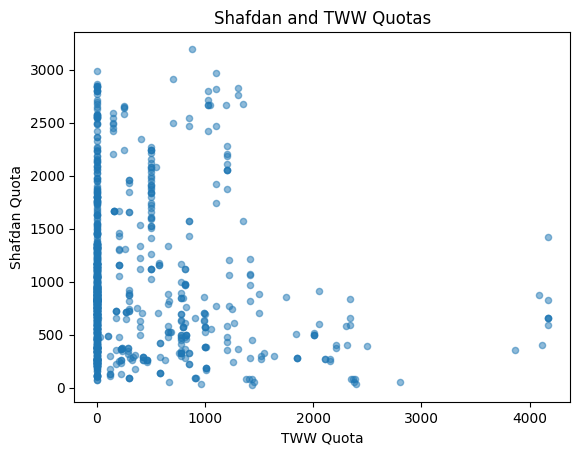

In [306]:
mydata[mydata['consumertype']!='FW'].plot.scatter(x='quota_t', y='quota_s', title='Shafdan and TWW Quotas',
                                                  xlabel='TWW Quota', ylabel='Shafdan Quota', alpha=0.5)

shafdan_status
Over 105% Quota      543
Under 95% Quota      266
In range of Quota    143
Name: count, dtype: int64


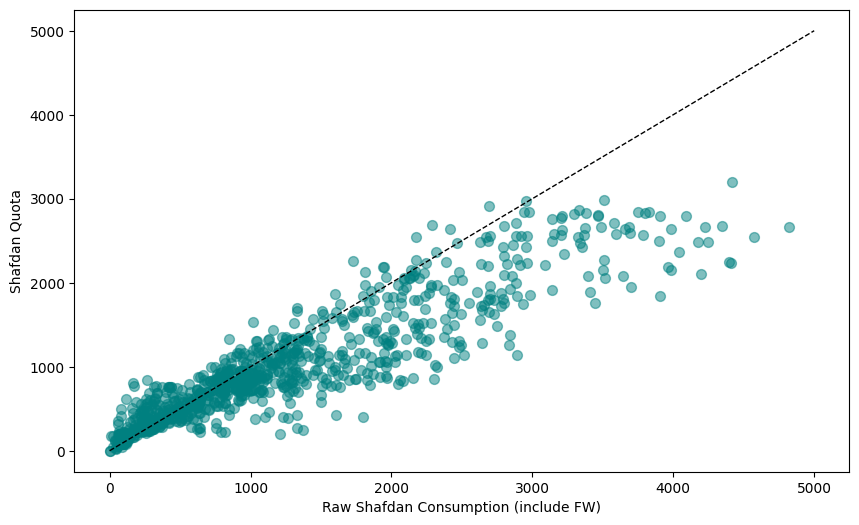

In [38]:
mydata.columns.tolist()
mydata['shafdan_status'] = np.where(mydata['shafdan_blended_consumption'] > 1.05*mydata['quota_s'], 'Over 105% Quota', 
                                    np.where(mydata['shafdan_blended_consumption'] < 0.95*mydata['quota_s'], 'Under 95% Quota', 'In range of Quota'))

print(mydata['shafdan_status'].value_counts())

mydata[['quota_s','shafdan_blended_consumption','shafdan_status']].plot.scatter(x='shafdan_blended_consumption',y='quota_s', c='teal', alpha=0.5, figsize=(10, 6), s=50)
plt.plot([0, 5000], [0, 5000], color='black', linestyle='--', linewidth=1
)

plt.xlabel('Raw Shafdan Consumption (include FW)')
plt.ylabel('Shafdan Quota')
plt.show()


In [24]:
mydata['shafdan_status'] = np.where(mydata['shafdan_blended_consumption'] > mydata['quota_s'], 'Over Quota', 
                                    np.where(mydata['shafdan_blended_consumption'] < mydata['quota_s'], 'Under Quota', 'At Quota'))

mydata['shafdan_status'].value_counts()

C:\Users\saarp\AppData\Local\Temp\ipykernel_30560\2292155151.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mydata['shafdan_status'] = np.where(mydata['shafdan_blended_consumption'] > mydata['quota_s'], 'Over Quota',


shafdan_status
Over Quota     613
Under Quota    336
At Quota         3
Name: count, dtype: int64

In [ ]:
z = mydata[mydata['quota_s']>mydata['ws']][['w1+w2+w3','ws']].plot.scatter(data=z ,x='ws', y='w1+w2+w3',')

SyntaxError: f-string: invalid syntax. Perhaps you forgot a comma? (1176042386.py, line 3)

In [ ]:
past_tariffs = pd.read_excel(r"Data\water tariffs overtime.xlsx")
past_tariffs['price_ratio1'] = past_tariffs['pf1'] / past_tariffs['ps']
past_tariffs['price_ratio2'] = past_tariffs['pf2'] / past_tariffs['ps']
past_tariffs['price_ratio3'] = past_tariffs['pf3'] / past_tariffs['ps']
past_tariffs.columns

past_tariffs['year'] = past_tariffs['date'].dt.year
past_tariffs['month'] = past_tariffs['date'].dt.month
past_tariffs['day'] = 1
past_tariffs['fixed_date'] = pd.to_datetime(past_tariffs[['year','month','day']])


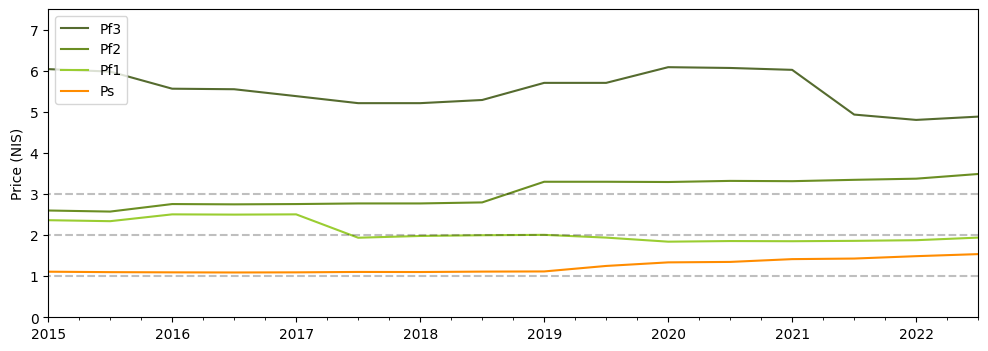

In [106]:
colors = ['darkolivegreen','olivedrab','yellowgreen','darkorange']
ax = past_tariffs[past_tariffs['year']>2014][['fixed_date','pf3','pf2', 'pf1', 'ps']].set_index('fixed_date').plot(figsize=(12, 4), color=colors)
ax.set_ylabel('Price (NIS)')
ax.set_ylim(0, 7.5)
ax.set_xlabel('')
ax.legend([ 'Pf3', 'Pf2','Pf1', 'Ps'], loc='upper left')
# ax.vlines(x=pd.to_datetime('2017-05-01'), ymin=0, ymax=7.5, color='grey', linestyle='--',alpha=0.5)  # Add vertical line to indicate change in t
ax.hlines(y=1, xmin=past_tariffs['fixed_date'].min(), xmax=past_tariffs['fixed_date'].max(), color='black', linestyle='--',alpha=0.25)
ax.hlines(y=2, xmin=past_tariffs['fixed_date'].min(), xmax=past_tariffs['fixed_date'].max(), color='black', linestyle='--',alpha=0.25)
ax.hlines(y=3, xmin=past_tariffs['fixed_date'].min(), xmax=past_tariffs['fixed_date'].max(), color='black', linestyle='--',alpha=0.25)

plt.show()

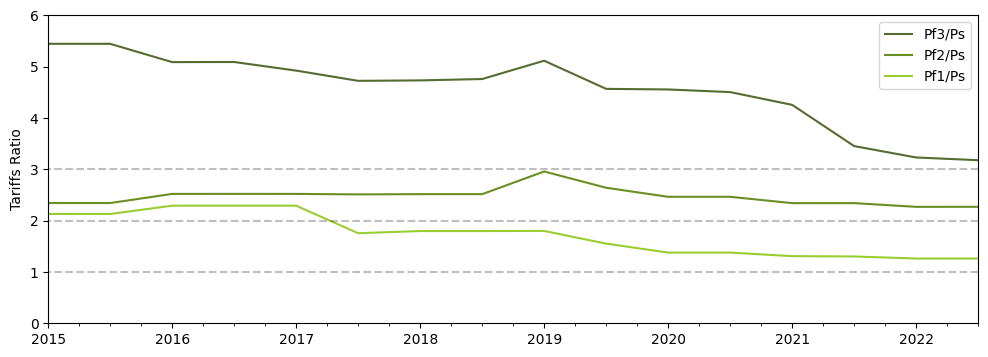

In [108]:
colors1 = ['darkolivegreen','olivedrab','yellowgreen']
ax = past_tariffs[past_tariffs['year']>2014][['fixed_date', 'price_ratio3','price_ratio2','price_ratio1']].set_index('fixed_date').plot(figsize=(12, 4), color=colors1)
ax.set_ylabel('Tariffs Ratio')
ax.set_xlabel('')
ax.set_ylim(0, 6)
ax.hlines(y=1, xmin=past_tariffs['fixed_date'].min(), xmax=past_tariffs['fixed_date'].max(), color='black', linestyle='--',alpha=0.25)
ax.hlines(y=2, xmin=past_tariffs['fixed_date'].min(), xmax=past_tariffs['fixed_date'].max(), color='black', linestyle='--',alpha=0.25)
ax.hlines(y=3, xmin=past_tariffs['fixed_date'].min(), xmax=past_tariffs['fixed_date'].max(), color='black', linestyle='--',alpha=0.25)

ax.legend(['Pf3/Ps', 'Pf2/Ps', 'Pf1/Ps'], loc='upper right')
plt.show()

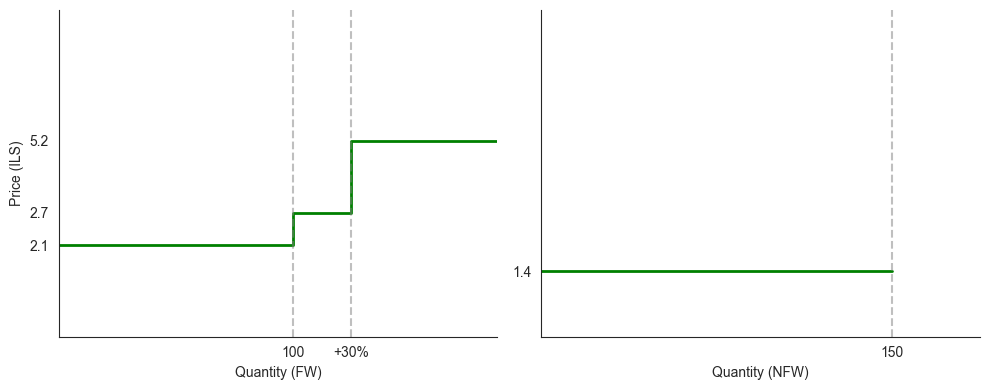

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_block_tariff(pf1, pf2, pf3, qf1, qf2, ps, qs, style='whitegrid', line_color='navy'):
    # Set style
    sns.set_style(style)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Left plot
    x_points = [0, qf1, qf1, qf2, qf2, max(qf2*1.5, qs)]
    y_points = [pf1, pf1, pf2, pf2, pf3, pf3]
    
    ax1.plot(x_points, y_points, color=line_color, linewidth=2)
    ax1.set_xlabel('Quantity (FW)')
    ax1.set_ylabel('Price (ILS)')
    # ax1.set_title('Increasing Block Tariff')
    
    ax1.set_yticks([pf1, pf2, pf3])
    ax1.set_yticklabels(['2.1', '2.7', '5.2'])
    
    ax1.set_xticks([qf1, qf2])
    ax1.set_xticklabels(['100', '+30%'])
    
    ax1.axvline(x=qf1, color='gray', linestyle='--', alpha=0.5)
    ax1.axvline(x=qf2, color='gray', linestyle='--', alpha=0.5)
    
    # Right plot
    ax2.plot([0, qs], [ps, ps], color=line_color, linewidth=2)
    ax2.set_xlabel('Quantity (NFW)')
    # ax2.set_title('Uniformed Price')
    
    ax2.set_yticks([ps])
    ax2.set_yticklabels(['1.4'])
    
    ax2.set_xticks([qs])
    ax2.set_xticklabels(['150'])
    
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim(0, 10)
        ax.set_xlim(0, max(qf2*1.5, qs*1.2))
        
    ax2.axvline(x=qs, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    return fig

# Example usage with style parameters
fig = plot_block_tariff(
    pf1=2.8, 
    pf2=3.8, 
    pf3=6.0, 
    qf1=2.0, 
    qf2=2.5, 
    ps=2.0,  
    qs=3.0,
    style='white',  # Options: darkgrid, whitegrid, dark, white, ticks
    line_color='green'   # Any matplotlib color name or hex code
)

plt.show()

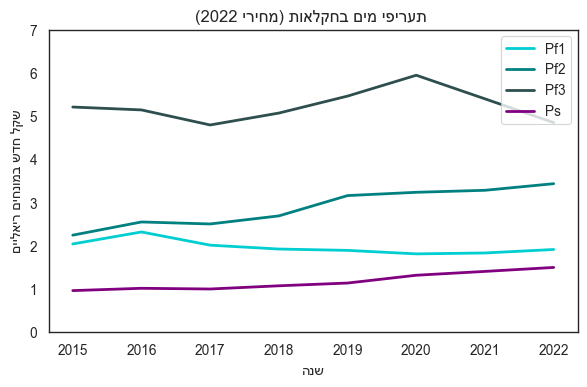

In [30]:
def plot_water_prices(data, style='white', title=" "):
    sns.set_style(style)
    sns.set_context("paper", font_scale=1.12)
    df = pd.DataFrame(data)
    df['year'] = df['year'].astype(str)
    colors = ['darkturquoise','teal', 'darkslategray','purple']

    df_melted = df.melt(id_vars='year', var_name='Tariff Type', value_name='Price')

    # Create the line plot
    plt.figure(figsize=(6, 4))
    sns.lineplot(
        data=df_melted,
        x='year',
        y='Price',
        hue='Tariff Type',
        palette=colors,  # Choose a built-in Seaborn color palette
        linewidth=2
    )

    # Add vertical lines for key years
    # plt.axvline(x='2019', color='black', linestyle='--', linewidth=1)
    # plt.axvline(x='2017', color='black', linestyle='--', linewidth=1)

    # Add labels, title, and limits
    tit = 'תעריפי מים בחקלאות )מחירי 2202('
    ylab = 'שקל חדש במונחים ריאליים'
    xlab = 'שנה'
    plt.title(tit[::-1] + title, fontsize=12)
    plt.xlabel(xlab[::-1], fontsize=10)
    plt.ylabel(ylab[::-1], fontsize=10)
    plt.xticks(rotation=0, ha='center')  # Rotate year labels for readability
    plt.ylim(0, 7)  # Set y-axis limit

    # Customize the legend
    plt.legend(loc='upper right')

    # Show grid and finalize layout
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Plot the data
year = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
pf1 = [mydata[mydata['year']==y]['pf1'].mean() for y in year]
pf2 = [mydata[mydata['year']==y]['pf2'].mean() for y in year]
pf3 = [mydata[mydata['year']==y]['pf3'].mean() for y in year]
ps = [mydata[mydata['year']==y]['ps'].mean() for y in year]
tariffs = {'year': year, 'Pf1': pf1, 'Pf2': pf2, 'Pf3': pf3, 'Ps': ps}
plot_water_prices(tariffs)

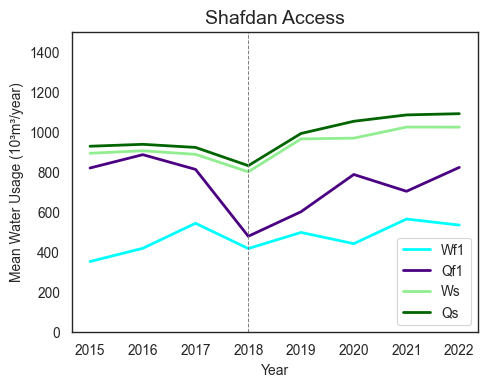

C:\Users\saarp\AppData\Local\Temp\ipykernel_2940\3135018201.py:15: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(


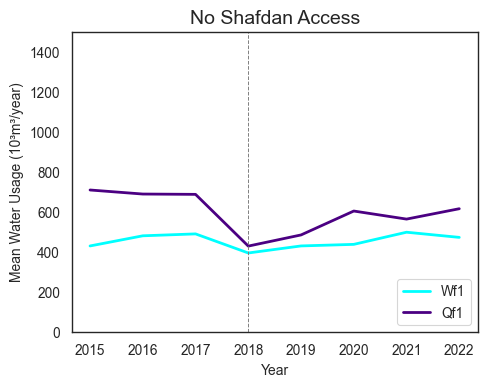

In [193]:
def plot_both_sources_usage(data, style="white", title=" "):
    sns.set_context("paper", font_scale=1.12)
    sns.set_style(style)  # Set the style
    df = pd.DataFrame(data)  # Convert the data dictionary to a DataFrame
    df['year'] = df['year'].astype(str)  # Convert years to strings for plotting
    
    # Melt the DataFrame for easier plotting with Seaborn
    df_melted = df.melt(id_vars='year', var_name='Source', value_name='Usage')

    colors = ['cyan',
               'indigo',
              'lightgreen', 'darkgreen']
    
    plt.figure(figsize=(5, 4))  # Adjust figure size for better visuals
    sns.lineplot(
        data=df_melted,
        x='year',
        y='Usage',
        hue='Source',
        palette=colors,  # Use a seaborn color palette
        linewidth=2
    )
    
    plt.axvline(x='2018', color='gray', linestyle='--', linewidth=0.7)  # Highlight a specific year
    plt.title('' + title, fontsize=14)
    plt.xlabel('Year', fontsize=10)
    plt.ylabel('Mean Water Usage (10³m³/year)', fontsize=10)
    plt.xticks(rotation=0, ha='center')  # Rotate x-ticks for better readability
    plt.ylim(0, 1500)  # Set y-axis limits
    plt.tight_layout()
    plt.legend(loc='lower right')
    plt.show()

# Plot the data
shafdan_access_df = mydata[mydata['consumertype']!='FW']
fw_only_df = mydata[mydata['consumertype']=='FW']
# tww_shafdan = mydata[mydata['consumertype']=='FW+S+T']

def usage_df(df):
    year = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
    # w1w2w3 = [df[df['year']==y]['w1+w2+w3'].mean() for y in year]
    w1 = [df[df['year']==y]['w1'].mean() for y in year]
    # w1w2 = [df[df['year']==y]['w1'].mean() + mydata[mydata['year']==y]['w2'].mean() for y in year]

    q1 = [df[df['year']==y]['q1'].mean() for y in year]
    # q1q2 = [df[df['year']==y]['q1'].mean() + mydata[mydata['year']==y]['q2'].mean() for y in year]

    if 1 in df['shafdan_access'].unique():

        ws = [df[df['year']==y]['ws'].mean() for y in year]
        qs = [df[df['year']==y]['quota_s'].mean() for y in year]

        usage = {'year': year, 'Wf1': w1,  'Qf1': q1, 'Ws': ws, 'Qs': qs}

    else:

        usage = {'year': year, 'Wf1': w1,  'Qf1': q1}


    return usage

shafdan_usage = usage_df(shafdan_access_df)
fw_usage = usage_df(fw_only_df)

plot_both_sources_usage(shafdan_usage, title='Shafdan Access')
plot_both_sources_usage(fw_usage, title='No Shafdan Access')


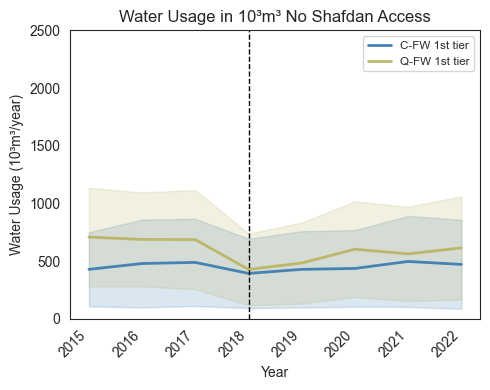

In [29]:
def plot_dual_water_usage_with_ci(data, 
                                source1='w1', 
                                source2='q1', 
                                label1='C-FW 1st tier', 
                                label2='Q-FW 1st tier',
                                color1='steelblue',
                                color2='darkkhaki',
                                style="white", 
                                title=" "):

    sns.set_style(style)
    
    # Create year list
    years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
    
    # Calculate means and standard deviations for both sources
    means1, means2 = [], []
    stds1, stds2 = [], []
    
    for year in years:
        year_data = data[data['year'] == year]
        
        # First source
        means1.append(year_data[source1].mean())
        stds1.append(year_data[source1].std())
        
        # Second source
        means2.append(year_data[source2].mean())
        stds2.append(year_data[source2].std())
    
    # Create the plot
    plt.figure(figsize=(5, 4))
    
    # Plot first source
    plt.plot(range(len(years)), means1, color=color1, linewidth=2, label=label1)
    plt.fill_between(
        range(len(years)),
        np.array(means1) - np.array(stds1),
        np.array(means1) + np.array(stds1),
        alpha=0.2,
        color=color1
    )
    
    # Plot second source
    plt.plot(range(len(years)), means2, color=color2, linewidth=2, label=label2)
    plt.fill_between(
        range(len(years)),
        np.array(means2) - np.array(stds2),
        np.array(means2) + np.array(stds2),
        alpha=0.2,
        color=color2
    )
    
    plt.axvline(x=3, color='black', linestyle='--', linewidth=1)  # Highlight 2018
    plt.title(f'Water Usage in 10³m³ {title}', fontsize=12)
    plt.xlabel('Year', fontsize=10)
    plt.ylabel('Water Usage (10³m³/year)', fontsize=10)
    plt.xticks(range(len(years)), years, rotation=45, ha='right')
    plt.ylim(0, 2500)
    plt.tight_layout()
    plt.legend(fontsize='small', loc='upper right')
    plt.show()

# Plot for fresh water and quota (no Shafdan access)
plot_dual_water_usage_with_ci(
    fw_only_df,
    source1='w1',
    source2='q1',
    label1='C-FW 1st tier',
    label2='Q-FW 1st tier',
    title='No Shafdan Access'
)


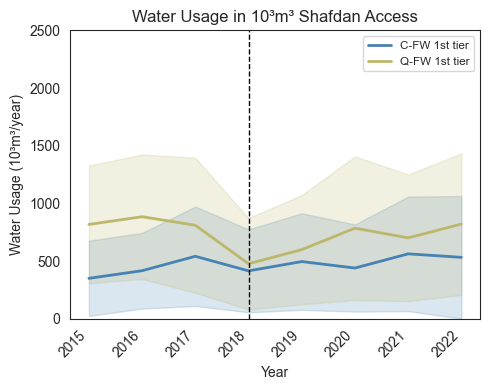

In [ ]:
# Plot for fresh water and quota (Shafdan access)
plot_dual_water_usage_with_ci(
    shafdan_access_df,
    source1='w1',
    source2='q1',
    label1='C-FW 1st tier',
    label2='Q-FW 1st tier',
    title='Shafdan Access'
)


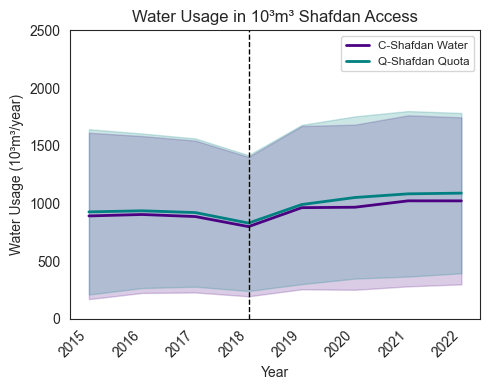

In [25]:
# Plot for Shafdan water and quota
plot_dual_water_usage_with_ci(
    shafdan_access_df,
    source1='ws',
    source2='quota_s',
    label1='C-Shafdan Water',
    label2='Q-Shafdan Quota',
    color1='indigo',
    color2='teal',
    title='Shafdan Access'
)

#### Using Hausman to Determinate Tariffs

In [9]:
s_base_exog_vars = ['ps','quota_s']
f_base_exog_vars = ['pf3','q1']
expelantories = ['Season Avg Temp (May-Sept)','Preseason Perc (April-May)','Postseason Perc (September-October)']

f_additional_vars_list = ['FWBS2','delta_pf_tag','q_delta_BS_fw','S x q_delta_BS_fw']
s_additional_vars_list = ['FWBS1','simple(q_delta_ps)','sqr_BS2_tag','sqr_BSS_tag']


def fe_s_results(df,additional_vars_list = s_additional_vars_list, id = 'consumernumber'):
    """
    Fixed Effects model for Shafdan Water consumption
    """
    # Filter for FW+S consumers
    mydata_s = df[df['consumertype'] == 'FW+S']
    my_df2 = mydata_s.set_index([id, 'year'])
    
    # Prepare variables for fixed effects model
    Y = my_df2['ws']
    X = my_df2[s_base_exog_vars + additional_vars_list + 
               [var for var in expelantories if var != 'shafdan_access']]
    # Add a constant (intercept) to the model
    X = sm.add_constant(X)
    # Estimate fixed effects model
    s_mod_fe = PanelOLS(Y, X, 
                        entity_effects=True)  # entity_effects=True for fixed effects
    
    # Fit the model with clustered standard errors
    s_results = s_mod_fe.fit(cov_type='clustered', 
                            cluster_entity=True)
    
    return s_results

def re_s_results(df,additional_vars_list = s_additional_vars_list, id = 'consumernumber'):
    mydata_s = df[df['consumertype'] == 'FW+S']
    my_df2 = mydata_s.set_index([id, 'year'])
    s_exog = (my_df2[s_base_exog_vars + additional_vars_list + [var for var in expelantories if var != 'shafdan_access']])
    s_exog = sm.add_constant(s_exog)
    s_mod_re = RandomEffects(my_df2['ws'], s_exog)
    s_results = s_mod_re.fit()
    return s_results

def fe_fw_results(df,f_additional_vars_list=f_additional_vars_list, id = 'consumernumber'):
    """
    Fixed Effects model for Fresh Water consumption
    """
    my_df1 = df.set_index([id, 'year'])
    # Prepare variables for fixed effects model
    Y = my_df1['w1+w2+w3']
    X = my_df1[f_base_exog_vars + expelantories + f_additional_vars_list]
    # Add a constant (intercept) to the model
    X = sm.add_constant(X)

    # Estimate fixed effects model
    fw_mod_fe = PanelOLS(Y, X, 
                         entity_effects=True)  # entity_effects=True for fixed effects
    
    # Fit the model with clustered standard errors
    fw_results = fw_mod_fe.fit(cov_type='clustered', 
                            cluster_entity=True)
    
    return fw_results

def re_fw_results(df,f_additional_vars_list=f_additional_vars_list, id = 'consumernumber'):
    my_df1 = df.set_index([id, 'year'])
    fw_exog_t = (my_df1[f_base_exog_vars + expelantories + f_additional_vars_list])
    fw_exog_t = sm.add_constant(fw_exog_t)
    fw_mod_re = RandomEffects(my_df1['w1+w2+w3'], fw_exog_t)
    fw_results = fw_mod_re.fit()

    return fw_results

fw_pricing_rate = np.arange(0.7, 1.05, 0.05)
shafdan_pricing_rate = np.arange(0.0, 0.75, 0.05)
for f_rate in fw_pricing_rate:
    for s_rate in shafdan_pricing_rate:
        mydata = tarrifs_variables_and_cleaning(df, f_rate, s_rate)
        s_hausman = 100
        f_hausman = 100
        
        s_hausman_test, s_pval = hausman_test(fe_s_results(mydata), re_s_results(mydata))
        if s_hausman_test > 20:
            if s_hausman_test < s_hausman:
                s_hausman = s_hausman_test
                s_comb = [f_rate,s_rate, round(s_hausman_test,3),round(s_pval,3)]

        f_hausman_test, f_pval = hausman_test(fe_fw_results(mydata), re_fw_results(mydata))
        if f_hausman_test > 20:
            if f_hausman_test < f_hausman:
                f_hausman = f_hausman_test
                f_comb = [f_rate,s_rate, round(f_hausman_test,3),round(f_pval,3)]

print('Best for fw')
print(f"july rate: {f_comb[0]}")
print(f"s july rate: {f_comb[1]}")
print(f"hausman test: {f_comb[2]}")
print(f"p_value: {f_comb[3]}")

print('Best for shafdan')
print(f"july rate: {s_comb[0]}")
print(f"s july rate: {s_comb[1]}")
print(f"hausman test: {s_comb[2]}")
print(f"p_value: {s_comb[3]}")
        


Best for fw


NameError: name 'f_comb' is not defined

#### Using CV test for optimizal tariff combination

In [274]:

# def manual_prediction(row, coefficients, fe_effect=0):
#     # Include the fixed effect in the prediction
#     return (row[coefficients.index] * coefficients).sum() + fe_effect

pricing_rate = np.arange(0.0, 1.05, 0.05)
d_rates={}
for rate in pricing_rate:
    mydata = tarrifs_variables_and_cleaning(df, rate, 1.0)

    base_exog_vars = ['pf3', 'q1']
    additional_vars_list = ['FWBS2','delta_pf_tag','q_delta_BS_fw','S x q_delta_BS_fw']
    expelantories  = ['Season Avg Temp (May-Sept)','Preseason Perc (April-May)',
                   'Postseason Perc (September-October)','tikun'
                   ]
    
    my_df = mydata.set_index(['consumernumber', 'year'])

    # Prepare data for fixed effects
    current_vars = base_exog_vars + expelantories + additional_vars_list
    Y = my_df['w1+w2+w3']
    X = my_df[current_vars]
    X = sm.add_constant(X)
    
    # Estimate fixed effects model
    mod_fe = PanelOLS(Y, X, entity_effects=True)
    results_model = mod_fe.fit(cov_type='clustered', cluster_entity=True)

    CV_re = 0
    CV_r = 0
    CV_df = mydata.copy()



    # Iterate through each consumer number
    for con in mydata['consumernumber'].unique():
        # Train the model by excluding one consumer (leave-one-out)
        train = CV_df[CV_df['consumernumber'] != con].copy()
        train = train.set_index(['consumernumber', 'year'])
        exog_vars1 = base_exog_vars + expelantories + additional_vars_list


        # Prepare training data
        Y_train = train['w1+w2+w3']
        X_train = train[current_vars]
        X_train = sm.add_constant(X_train)
        # Estimate fixed effects model on training data
        mod_fe_cv = PanelOLS(Y_train, X_train, entity_effects=True)
        fe_res = mod_fe_cv.fit(cov_type='clustered', cluster_entity=True)
        coefficients = fe_res.params


        # Test set for the omitted consumer (we predict for them)
        test = CV_df[CV_df['consumernumber'] == con].copy()
        test = test.set_index(['consumernumber', 'year'])

        X_test = test[current_vars]
        predicted_base = (X_test * coefficients).sum(axis=1)
        fe_effect = (test['w1+w2+w3'] - predicted_base).mean()

        
        # Make predictions including the fixed effect
        test['manual_predictions'] = test.apply(
            lambda row: manual_prediction(row, coefficients, fe_effect), axis=1)
        
        # Calculate the cross-validation error (squared differences for this consumer)
        cv_cons = (((test['w1+w2+w3'] - test['manual_predictions'])**2)).sum()
        avg_cv = cv_cons / len(test)

        CV_r += avg_cv

        CV_re = CV_r / len(mydata['consumernumber'].unique())

    d_rates[rate] = CV_re


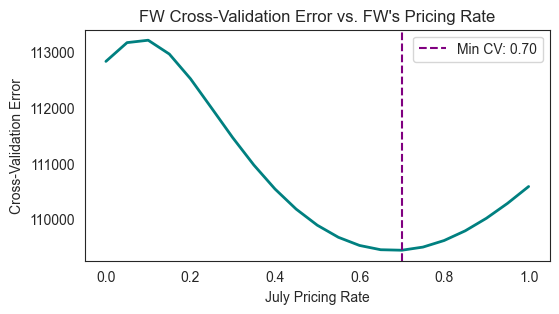

In [275]:
sns.set_style("white")
plt.figure(figsize=(6, 3))
plt.plot(list(d_rates.keys()), list(d_rates.values()), color='teal', linewidth=2)
# I want to create vertical lines at the minimal values
min_rate = min(d_rates, key=d_rates.get)
plt.axvline(x=min_rate, color='purple', linestyle='--', label=f'Min CV: {min_rate:.2f}')
plt.legend()
plt.title("FW Cross-Validation Error vs. FW's Pricing Rate")    
plt.xlabel('July Pricing Rate')
plt.ylabel('Cross-Validation Error')
plt.show()

In [276]:
pricing_rate = np.arange(0.0, 1.05, 0.05)
d_rates_s={}

for rate in pricing_rate:
    mydata = tarrifs_variables_and_cleaning(df, 0.7, rate)
    mydata_s = mydata[mydata['consumertype']=='FW+S'].copy()

    s_base_exog_vars = ['ps','quota_s']
    s_expelantories  = ['Season Avg Temp (May-Sept)','Preseason Perc (April-May)','Postseason Perc (September-October)','tikun']
    s_additional_vars_list = ['simple(q_delta_ps)','sqr_BS2_tag','sqr_BSS_tag','FWBS1']

    my_df = mydata_s.set_index(['consumernumber', 'year'])

    # exog = sm.add_constant(my_df[base_exog_vars + expelantories + diff_vars])
    # mod_re = RandomEffects(my_df['ws'], exog, check_rank=False)
    # results_model = mod_re.fit()

    # Prepare data for fixed effects
    current_vars = s_base_exog_vars + s_expelantories + s_additional_vars_list
    Y = my_df['ws']
    X = my_df[current_vars]
    X = sm.add_constant(X)
    # Estimate fixed effects model
    mod_fe = PanelOLS(Y, X, entity_effects=True)
    results_model = mod_fe.fit(cov_type='clustered', cluster_entity=True)
    
    CV_re = 0
    CV_r = 0
    CV_df = mydata_s.copy()

    # Iterate through each consumer number
    for con in mydata_s['consumernumber'].unique():
        # Train the model by excluding one consumer (leave-one-out)
        train = CV_df[CV_df['consumernumber'] != con].copy()
        train = train.set_index(['consumernumber', 'year'])
        exog_vars1 = s_base_exog_vars + s_expelantories + s_additional_vars_list


        # Prepare training data
        Y_train = train['ws']
        X_train = train[current_vars]
        X_train = sm.add_constant(X_train)
        # Estimate fixed effects model on training data
        mod_fe_cv = PanelOLS(Y_train, X_train, entity_effects=True)
        fe_res = mod_fe_cv.fit(cov_type='clustered', cluster_entity=True)
        coefficients = fe_res.params


        # Test set for the omitted consumer (we predict for them)
        test = CV_df[CV_df['consumernumber'] == con].copy()
        test = test.set_index(['consumernumber', 'year'])

        X_test = test[current_vars]
        predicted_base = (X_test * coefficients).sum(axis=1)
        fe_effect = (test['ws'] - predicted_base).mean()


        # Test set for the omitted consumer (we predict for them)
        test = CV_df[CV_df['consumernumber'] == con].copy()
        test = test.set_index(['consumernumber', 'year'])
        test_exog = sm.add_constant(test[exog_vars1])

        # Make predictions including the fixed effect
        test['manual_predictions'] = test.apply(
            lambda row: manual_prediction(row, coefficients, fe_effect), axis=1)

        # Calculate the cross-validation error (squared differences for this consumer)
        cv_cons = (((test['ws'] - test['manual_predictions'])**2)).sum()
        avg_cv = cv_cons / len(test)

        CV_r += avg_cv

        CV_re = CV_r / len(mydata_s['consumernumber'].unique())

    d_rates_s[rate] = CV_re


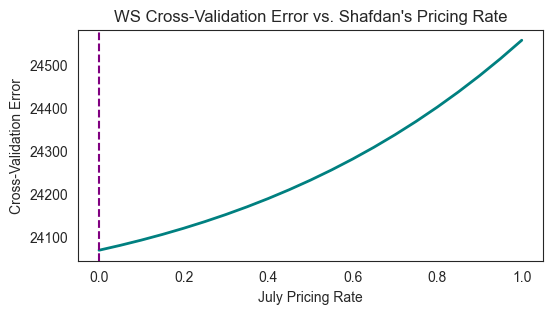

In [277]:
sns.set_style("white")
plt.figure(figsize=(6, 3))
plt.plot(list(d_rates_s.keys()), list(d_rates_s.values()), color='teal', linewidth=2)
min_rate_s = min(d_rates_s, key=d_rates_s.get)
plt.axvline(x=min_rate_s, color='purple', linestyle='--', label=f'Min Rate: {min_rate_s:.2f}')

plt.title("WS Cross-Validation Error vs. Shafdan's Pricing Rate")    
plt.xlabel('July Pricing Rate')
plt.ylabel('Cross-Validation Error')
plt.show() 

#### Shafdan Building Eq

In [146]:
base_exog_vars = ['ps','quota_s']
expelantories = ['Season Avg Temp (May-Sept)', 
                'Preseason Perc (April-May)',
                'Postseason Perc (September-October)','trend','quota_t'


]

diff_vars = ['FWBS1','sqr_dps', 'qs_dFWBS',


            

]
   
diff_vars2 = ["1",
              '(ps)xsqr(qs)',

                'delta_FWBS',
                'BSS_tag',
                'BS1_tag',
                'BS2_tag',
                'delta_ps_tag',
                'delta_pf_tag',
                'q_delta_BS_tag',
                # 'sqr_BS1_tag',
                # 'sqr_BS2_tag',
                # 'sqr_BSS_tag',

                'simple(q_delta_ps)',
                'simple(q_delta_BS_tag)',
                'delta_BS_fw',
                'q_delta_BS_fw',
                'nT x delta_FWBS',

                
                'sim_q_delta_FWBS',
                'q_delta_FWBS',
                'q_delta_pf','nT x q_delta_FWBS','T x q_delta_BS_fw',
                 'FWBS2','sqr_FWBS2',
                #    'q2_FWBS2','q2_dFWBS','qs_FWBS2',
                # '(ps)x(qs)','(ps)xsqr(qs)','delta_ps',
]
              
         
            
mydata_s = mydata[mydata['consumertype']!='FW'].copy()
my_df = mydata_s.set_index(['consumernumber', 'year'])
exog_vars = base_exog_vars + expelantories + diff_vars + diff_vars2[1:]
summary_table = pd.DataFrame(index=exog_vars + ['Constant', 'N obs', 'F-statistic', 'F p-value', 'R-squared'])

for i in range(len(diff_vars2)):
    print(f"Processing variable: {diff_vars2[i]}")
    try:
        CV_re = 0
        squared_errors = 0
        model_name = f'Model {i+1}'

        if i==0:
            current_vars = base_exog_vars + expelantories + diff_vars

        else:
            current_vars = base_exog_vars + expelantories + diff_vars + [diff_vars2[i]]

        # Prepare data for fixed effects
        Y = my_df['ws']
        X = my_df[current_vars]
        # Add a constant to the model
        X = sm.add_constant(X)
        
        # Estimate fixed effects model
        mod_fe = PanelOLS(Y, X, entity_effects=True,check_rank=False)
        results_model = mod_fe.fit(cov_type='clustered', cluster_entity=True)

        mod_re = RandomEffects(Y, X)
        re_results_model = mod_re.fit()

        hausman_stat, hausman_pval = hausman_test(results_model, re_results_model)
        
        present_vars = [var for var in exog_vars if var in results_model.params.index]
        coefficients_with_stars = results_model.params[present_vars].astype(str)

        for var in present_vars:
            star = add_significance_stars(results_model.pvalues[var])
            coefficients_with_stars[var] = f"{results_model.params[var]:.6f}{star}"

        # Add coefficients to the summary table
        summary_table[model_name] = coefficients_with_stars
        const_star = add_significance_stars(results_model.pvalues['const'])
        summary_table.loc['Constant', model_name] = f"{results_model.params['const']:.3f}{const_star}"
        summary_table.loc['N obs', model_name] = results_model.nobs

        # Add F-statistic and its p-value
        summary_table.loc['F-statistic', model_name] = f"{results_model.f_statistic_robust.stat:.4f}"
        summary_table.loc['F p-value', model_name] = f"{results_model.f_statistic_robust.pval:.4f}"
        # Add R-squared values
        summary_table.loc['R-squared', model_name] = f"{results_model.rsquared:.4f}"

        MSSE = np.mean(results_model.resids ** 2)

        AIC,BIC = calculate_aic_bic_approx(results_model, len(Y))

        CV_r = 0
        CV_df = mydata_s.copy()

        # Iterate through each consumer number
        for con in mydata_s['consumernumber'].unique():
            # Train the model by excluding one consumer (leave-one-out)
            train = CV_df[CV_df['consumernumber'] != con].copy()
            train = train.set_index(['consumernumber', 'year'])


            # Prepare training data
            Y_train = train['ws']
            X_train = train[current_vars]
            X_train = sm.add_constant(X_train)
            
            # Estimate fixed effects model on training data
            
            mod_fe_cv = PanelOLS(Y_train, X_train, entity_effects=True)
            fe_res = mod_fe_cv.fit(cov_type='clustered', cluster_entity=True)

            coefficients = fe_res.params

            # Test set for the omitted consumer (we predict for them)
            test = CV_df[CV_df['consumernumber'] == con].copy()
            test = test.set_index(['consumernumber', 'year'])

            # Calculate consumer-specific fixed effect using mean residual
            X_test = test[current_vars]
            predicted_base = (X_test * coefficients).sum(axis=1)
            fe_effect = (test['ws'] - predicted_base).mean()

            # Make predictions including the fixed effect
            test['manual_predictions'] = test.apply(
                lambda row: manual_prediction(row, coefficients, fe_effect), axis=1)
            
            # Calculate the cross-validation error (squared differences for this consumer)
            cv_cons = (((test['ws'] - test['manual_predictions'])**2)).sum()
            avg_cv = cv_cons / len(test)

            CV_r += avg_cv

        # Final cross-validation result (mean error across all consumers)
        CV_re = CV_r / len(mydata_s['consumernumber'].unique())

        # summary_table.loc['CV-RE', model_name] = f"{CV_re:.0f}"

        summary_table.loc['MSSE', model_name] = f"{MSSE:.3f}"
        summary_table.loc['CV-RE', model_name] = f"{CV_re:.0f}"
        summary_table.loc['AIC', model_name] = f"{AIC:.2f}"
        summary_table.loc['Hausman', model_name] = f"{hausman_stat:.2f}"

    except Exception as e:
        print(f"Error with variable {diff_vars2[i]}: {str(e)}")
        continue  # Continue to the next variable

# Fill NaN values with empty strings
summary_table = summary_table.fillna('')

summary_table

Processing variable: 1
Processing variable: (ps)xsqr(qs)
Processing variable: delta_FWBS
Processing variable: BSS_tag
Processing variable: BS1_tag
Processing variable: BS2_tag
Processing variable: delta_ps_tag
Processing variable: delta_pf_tag
Processing variable: q_delta_BS_tag
Processing variable: simple(q_delta_ps)
Processing variable: simple(q_delta_BS_tag)
Processing variable: delta_BS_fw
Processing variable: q_delta_BS_fw
Processing variable: nT x delta_FWBS
Processing variable: sim_q_delta_FWBS
Processing variable: q_delta_FWBS
Processing variable: q_delta_pf
Processing variable: nT x q_delta_FWBS
Processing variable: T x q_delta_BS_fw
Processing variable: FWBS2
Processing variable: sqr_FWBS2


,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8,Model 9,Model 10,...,Model 12,Model 13,Model 14,Model 15,Model 16,Model 17,Model 18,Model 19,Model 20,Model 21
ps,-113.223702**,-155.057649***,-105.824945*,-128.828907**,-86.044769,-106.886422**,-124.748395**,-139.092594***,-126.102551**,-128.828907**,...,-90.368280*,-110.405289**,-113.049916**,-110.081910**,-109.904167**,-107.048774*,-111.821234**,-112.589361**,-105.824945*,-109.393073**
quota_s,0.817736***,0.745205***,0.814263***,0.825230***,0.763632***,0.823458***,0.811712***,0.811724***,0.780628***,0.825230***,...,0.821881***,0.810290***,0.817667***,0.810629***,0.810941***,0.814514***,0.813499***,0.816834***,0.814263***,0.810767***
Season Avg Temp (May-Sept),58.796071***,51.777787***,57.944656***,55.935012***,57.541361***,59.155774***,48.612677**,47.704547**,54.368852***,55.935012***,...,59.506780***,58.283620***,58.749660***,57.899462***,57.480461***,58.557131***,57.203855***,59.037921***,57.944656***,58.644379***
Preseason Perc (April-May),-1.085900***,-1.056812***,-1.107079***,-1.067991***,-1.182866***,-1.072095***,-1.444312***,-1.432645***,-1.086335***,-1.067991***,...,-1.068860***,-1.109907***,-1.086374***,-1.115753***,-1.124450***,-1.091624***,-1.108091***,-1.089858***,-1.107079***,-1.096182***
Postseason Perc (September-October),1.042215***,0.967720***,1.017104***,1.049566***,1.066382***,0.982471***,1.459280***,1.469621***,1.084293***,1.049566***,...,0.885543***,1.030869***,1.041355***,1.034069***,1.036887***,1.012817***,1.035909***,1.041942***,1.017104***,1.018894***
trend,16.544781**,18.532018**,15.044138*,18.061247**,11.876121,14.795934*,22.860077***,23.454708***,18.970287***,18.061247**,...,10.831311,15.905280**,16.502137**,15.891916**,15.870988**,15.223473*,16.087243**,16.467767**,15.044138*,15.520182**
quota_t,-0.035144*,-0.030796*,-0.036297**,-0.033372*,-0.034387*,-0.035634**,-0.038105**,-0.038107**,-0.032878*,-0.033372*,...,-0.036312**,-0.037745**,-0.035201**,-0.037526**,-0.037553**,-0.036132**,-0.035909**,-0.035126*,-0.036297**,-0.037264**
FWBS1,0.020744***,0.012526,0.021402**,0.016995*,-0.011999,0.023274**,0.019216**,0.019219**,0.015627*,0.016995*,...,0.020729***,0.022783***,0.020750***,0.022106***,0.021482***,0.024856*,0.020835***,0.021185***,0.023700**,0.024689**
sqr_dps,46.272801***,42.203673**,44.700905***,52.600421***,40.972697**,43.132887***,64.867752***,75.575163***,51.796791***,52.600421***,...,36.660991**,45.764326***,46.219301***,45.775160***,45.706210***,44.738131***,45.627669***,46.340150***,44.700905***,44.716905***
qs_dFWBS,-0.000002,-0.000004,-0.000003,-0.000003,-0.000003,-0.000003,-0.000002,-0.000002,0.000004,-0.000003,...,-0.000006,-0.000005,-0.000002,-0.000004,-0.000004,-0.000003,-0.000003,-0.000002,-0.000003,-0.000004


#### shafdan modeling - Comperison Table

In [10]:
s_base_exog_vars = ['ps']
s_expelantories = ['Season Avg Temp (May-Sept)','Preseason Perc (April-May)','Postseason Perc (September-October)','trend','quota_t'

                    ]
s_diff_vars = ['quota_s','FWBS1','sqr_dps', 'qs_dFWBS','delta_FWBS',]
#  '(ps)xsqr(qs)','sqr_dps','T x q_delta_BS_fw','nT x FWBS1','nT x delta_FWBS', 'BSS_tag'                   

mydata_s = mydata[mydata['consumertype'] != 'FW']
my_df = mydata_s.set_index(['consumernumber', 'year'])

exog_vars = s_base_exog_vars + s_expelantories +  s_diff_vars
summary_table = pd.DataFrame(index=exog_vars + ['Constant', 'N obs'])#, 'F-statistic', 'F p-value', 'R-squared'

for i, num in enumerate([1,2,3,4,5]):
    CV_re = 0
    squared_errors = 0
    model_name = f'Model {i+1}'

    current_vars = s_base_exog_vars + s_expelantories + s_diff_vars[:num]

    # Prepare data for fixed effects
    Y = my_df['ws']
    X = my_df[current_vars]
    X = sm.add_constant(X)
    
    # Estimate fixed effects model
    mod = PanelOLS(Y, X, entity_effects=True,check_rank=False)
    results_model = mod.fit(cov_type='clustered', cluster_entity=True)

    re_mod = RandomEffects(Y, X)
    re_results_model = re_mod.fit()

    hausman_stat, p_value = hausman_test(results_model, re_results_model)

    present_vars = [var for var in exog_vars if var in results_model.params.index]
    coefficients_with_stars = results_model.params[present_vars].astype(str)

    for var in present_vars:
        star = add_significance_stars(results_model.pvalues[var])
        coefficients_with_stars[var] = f"{results_model.params[var]:.6f}{star}"

    # Add coefficients to the summary table
    summary_table[model_name] = coefficients_with_stars
    const_star = add_significance_stars(results_model.pvalues['const'])
    summary_table.loc['Constant', model_name] = f"{results_model.params['const']:.3f}{const_star}"
    summary_table.loc['N obs', model_name] = results_model.nobs


    MSSE = np.mean(results_model.resids ** 2)

    AIC,BIC = calculate_aic_bic_approx(results_model, len(Y))

    CV_r = 0
    CV_df = mydata_s.copy()

    # Iterate through each consumer number
    for con in mydata_s['consumernumber'].unique():
        # Train the model by excluding one consumer (leave-one-out)
        train = CV_df[CV_df['consumernumber'] != con].copy()
        train = train.set_index(['consumernumber', 'year'])


        # Prepare training data
        Y_train = train['ws']
        X_train = train[current_vars]
        X_train = sm.add_constant(X_train)
        
        # Estimate fixed effects model on training data
        mod_cv = PanelOLS(Y_train, X_train, entity_effects=True)
        # mod_cv = RandomEffects(Y_train, X_train)

        fe_res = mod_cv.fit(cluster_entity=True, cov_type = 'clustered')
        coefficients = fe_res.params

        # Test set for the omitted consumer (we predict for them)
        test = CV_df[CV_df['consumernumber'] == con].copy()
        test = test.set_index(['consumernumber', 'year'])

        # Calculate consumer-specific fixed effect using mean residual
        X_test = test[current_vars]
        predicted_base = (X_test * coefficients).sum(axis=1)
        fe_effect = (test['ws'] - predicted_base).mean()

        # Make predictions including the fixed effect
        test['manual_predictions'] = test.apply(
            lambda row: manual_prediction(row, coefficients, fe_effect), axis=1)
        
        # Calculate the cross-validation error (squared differences for this consumer)
        cv_cons = (((test['ws'] - test['manual_predictions'])**2)).sum()
        avg_cv = cv_cons / len(test)

        CV_r += avg_cv

    # Final cross-validation result (mean error across all consumers)
    CV_re = CV_r / len(mydata_s['consumernumber'].unique())

    # summary_table.loc['CV-RE', model_name] = f"{CV_re:.0f}"

    summary_table.loc['CV-RE', model_name] = f"{CV_re:.0f}"
    summary_table.loc['AIC', model_name] = f"{AIC:.0f}"    
    summary_table.loc['MSSE', model_name] = f"{MSSE:.3f}"
    summary_table.loc['F-statistic', model_name] = f"{results_model.f_statistic_robust.stat:.3f}"
    # summary_table.loc['F p-value', model_name] = f"{results_model.f_statistic_robust.pval:.3f}"
    summary_table.loc['R-squared', model_name] = f"{results_model.rsquared:.3f}"
    summary_table.loc['Hausman', model_name] = f"{hausman_stat:.3f}"

    r2 = results_model.rsquared
    n = results_model.nobs
    k = results_model.params.shape[0] - 1  

    adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - k - 1)

    summary_table.loc['Adjusted R-squared', model_name] = f'{adj_r2:.3f}'



summary_table = summary_table.fillna('')
summary_table

,Model 1,Model 2,Model 3,Model 4,Model 5
ps,-55.927108,-66.046208,-88.405197*,-103.088100*,-96.032799*
Season Avg Temp (May-Sept),39.605110*,46.590995**,62.037519***,61.622875***,60.788418***
Preseason Perc (April-May),-1.165599***,-1.249576***,-1.054653***,-1.051734***,-1.072052***
Postseason Perc (September-October),0.523590**,0.544866***,0.979604***,1.038264***,1.014861***
trend,2.840292,0.236667,13.596202**,16.389085**,14.958838*
quota_t,-0.034715*,-0.035173*,-0.034313*,-0.034406*,-0.035446**
quota_s,0.822696***,0.818386***,0.823675***,0.819251***,0.815945***
FWBS1,,0.020682***,0.023407***,0.020948***,0.021610**
sqr_dps,,,46.518389***,48.952466***,47.464289***
qs_dFWBS,,,,-0.000002,-0.000003


#### Final S model

In [10]:
s_base_exog_vars = ['ps','quota_s']
s_expelantories = ['Season Avg Temp (May-Sept)','Preseason Perc (April-May)','Postseason Perc (September-October)','trend','quota_t']
additional_vars_list_Mcv = ['FWBS1','sqr_dps', 'qs_dFWBS']

def fe_s_results(df,additional_vars_list = additional_vars_list_Mcv, id = 'consumernumber'):
    """
    Fixed Effects model for Shafdan Water consumption
    """
    # Filter for FW+S consumers
    mydata_s = df[df['consumertype'] != 'FW']
    my_df2 = mydata_s.set_index([id, 'year'])
    
    # Prepare variables for fixed effects model
    Y = my_df2['ws']
    X = my_df2[s_base_exog_vars + additional_vars_list + 
               [var for var in s_expelantories if var != 'shafdan_access']]
    # Add a constant (intercept) to the model
    X = sm.add_constant(X)
    # Estimate fixed effects model
    s_mod_fe = PanelOLS(Y, X, 
                        entity_effects=True)  # entity_effects=True for fixed effects
    
    # Fit the model with clustered standard errors
    s_results = s_mod_fe.fit(cov_type='clustered', 
                            cluster_entity=True)
    
    return s_results

def re_s_results(df,additional_vars_list = additional_vars_list_Mcv, id = 'consumernumber'):
    mydata_s = df[df['consumertype'] != 'FW']
    my_df2 = mydata_s.set_index([id, 'year'])
    s_exog = (my_df2[s_base_exog_vars + additional_vars_list + [var for var in s_expelantories if var != 'shafdan_access']])
    s_exog = sm.add_constant(s_exog)
    s_mod_re = RandomEffects(my_df2['ws'], s_exog)
    s_results = s_mod_re.fit()
    return s_results

sfe_results = fe_s_results(mydata)
sre_results = re_s_results(mydata)


s_hausman_stat, s_p_value = hausman_test(sfe_results, sre_results)

print(f'S Model that minimize {Minimization_method}')
print(f'Hausman Test Statistic: {s_hausman_stat:.3f}')
print(f'p-value: {s_p_value:.4f}')

# Result analysis
if s_p_value < 0.025:
    print("Reject the null hypothesis - FE model is more appropriate.")
else:
    print("Fail to reject the null hypothesis - RE model is more appropriate.")

print(sfe_results)


S Model that minimize CV
Hausman Test Statistic: 35.397
p-value: 0.0002
Reject the null hypothesis - FE model is more appropriate.
                          PanelOLS Estimation Summary                           
Dep. Variable:                     ws   R-squared:                        0.7753
Estimator:                   PanelOLS   R-squared (Between):              0.9598
No. Observations:                 951   R-squared (Within):               0.7753
Date:                Mon, Mar 17 2025   R-squared (Overall):              0.9528
Time:                        08:12:59   Log-likelihood                   -5335.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      280.47
Entities:                         128   P-value                           0.0000
Avg Obs:                       7.4297   Distribution:                  F(10,813)
Min Obs:                       3.0000                      

#### FW Building Eq

In [ ]:
base_exog_vars = ['pf1', 'q1']
expelantories  = ['Season Avg Temp (May-Sept)','Preseason Perc (April-May)','Postseason Perc (September-October)','trend','quota_t']
diff_vars = ['q_delta_BS_fw','FWBS1','S x FWBS2', 'S x FWBS1',









]
   
diff_vars2 = ['1',
                # 'delta_FWBS',
                # 'S x delta_pf_tag',
                # 'BSS_tag',
                # 'BS1_tag',
                # 'BS2_tag',
                # 'delta_BS_tag',
                # 'delta_pf_tag',
                # 'q_delta_BS_tag',
                'sqr_BS1_tag',
                'sqr_BS2_tag',
                'sqr_BSS_tag','delta_pf',
                'simple(q_delta_BS_tag)',
                'delta_BS_fw',
                'S x q_delta_BS_fw','nT x delta_FWBS',

                'S x delta_FWBS',
                'sim_q_delta_FWBS',
                'q_delta_FWBS','sqr_dps',
                'q_delta_pf','nT x FWBS1',
                # 'nT x q_delta_FWBS','T x delta_pf','T x q_delta_BS_fw',
                #   'S x qdFWBS','FWBS2','sqr_FWBS2', 'q2_FWBS2','q2_dFWBS','qs_FWBS2','qs_dFWBS',
               

            

 ]
                
# mydata['cv_index'] = range(1, len(mydata) + 1)
my_df = mydata.set_index(['consumernumber', 'year'])

exog_vars = base_exog_vars + expelantories + diff_vars + diff_vars2[1:]
summary_table = pd.DataFrame(index=exog_vars + ['Constant', 'N obs', 'F-statistic', 'F p-value', 'R-squared'])


for i in range(len(diff_vars2)):
    print(f"Processing variable: {diff_vars2[i]}")
    try:
        CV_re = 0
        squared_errors = 0
        model_name = f'Model {i+1}'

        if i == 0:
            current_vars = base_exog_vars + expelantories + diff_vars
        else:
            current_vars = base_exog_vars + expelantories + diff_vars + [diff_vars2[i]]

        # Prepare data for fixed effects
        Y = my_df['w1+w2+w3']
        X = my_df[current_vars]

        # Add a constant to the model
        X = sm.add_constant(X)

        # Estimate fixed effects model
        mod_fe = PanelOLS(Y, X, entity_effects=True, check_rank=False)
        results_model = mod_fe.fit(cov_type='clustered', cluster_entity=True)

        mod_re = RandomEffects(Y, X)
        re_results = mod_re.fit()

        hausman_stat, p_value = hausman_test(results_model, re_results)
        present_vars = [var for var in exog_vars if var in results_model.params.index]
        coefficients_with_stars = results_model.params[present_vars].astype(str)

        for var in present_vars:
            star = add_significance_stars(results_model.pvalues[var])
            coefficients_with_stars[var] = f"{results_model.params[var]:.6f}{star}"

        # Add coefficients to the summary table
        summary_table[model_name] = coefficients_with_stars
        const_star = add_significance_stars(results_model.pvalues['const'])
        summary_table.loc['Constant', model_name] = f"{results_model.params['const']:.3f}{const_star}"
        summary_table.loc['N obs', model_name] = results_model.nobs

        # Add F-statistic and its p-value
        summary_table.loc['F-statistic', model_name] = f"{results_model.f_statistic_robust.stat:.4f}"
        summary_table.loc['F p-value', model_name] = f"{results_model.f_statistic_robust.pval:.4f}"
        summary_table.loc['R-squared', model_name] = f"{results_model.rsquared:.4f}"

        MSSE = np.mean(results_model.resids ** 2)
        AIC, BIC = calculate_aic_bic_approx(results_model, len(Y))

        CV_r = 0
        for con in mydata['consumernumber'].unique():
            train = mydata[mydata['consumernumber'] != con].copy()
            train = train.set_index(['consumernumber', 'year'])
            Y_train = train['w1+w2+w3']
            X_train = train[current_vars]
            X_train = sm.add_constant(X_train)

            mod_fe_cv = PanelOLS(Y_train, X_train, entity_effects=True)
            fe_res = mod_fe_cv.fit(cov_type='clustered', cluster_entity=True)
            coefficients = fe_res.params

            test = mydata[mydata['consumernumber'] == con].copy()
            test = test.set_index(['consumernumber', 'year'])
            X_test = test[current_vars]

            predicted_base = (X_test * coefficients).sum(axis=1)
            fe_effect = (test['w1+w2+w3'] - predicted_base).mean()

            test['manual_predictions'] = test.apply(
                lambda row: manual_prediction(row, coefficients, fe_effect), axis=1)
            cv_cons = (((test['w1+w2+w3'] - test['manual_predictions']) ** 2)).sum()
            avg_cv = cv_cons / len(test)
            CV_r += avg_cv

        CV_re = CV_r / len(mydata['consumernumber'].unique())

        summary_table.loc['CV-RE', model_name] = f"{CV_re:.0f}"
        summary_table.loc['AIC', model_name] = f"{AIC:.2f}"
        summary_table.loc['Hausman', model_name] = f"{hausman_stat:.2f}"

    except Exception as e:
        print(f"Error with variable {diff_vars2[i]}: {str(e)}")
        continue  # Continue to the next variable

# Fill NaN values with empty strings
summary_table = summary_table.fillna('')
summary_table

Processing variable: 1
Processing variable: sqr_BS1_tag
Processing variable: sqr_BS2_tag
Processing variable: sqr_BSS_tag
Processing variable: delta_pf
Processing variable: simple(q_delta_BS_tag)
Processing variable: delta_BS_fw
Processing variable: S x q_delta_BS_fw
Processing variable: nT x delta_FWBS
Processing variable: S x delta_FWBS
Error with variable S x delta_FWBS: 
The model cannot be estimated. The included effects have fully absorbed
one or more of the variables. This occurs when one or more of the dependent
variable is perfectly explained using the effects included in the model.

The following variables or variable combinations have been fully absorbed
or have become perfectly collinear after effects are removed:

          const, pf1, q1, Season Avg Temp (May-Sept), Preseason Perc (April-May), Postseason Perc (September-October), trend, quota_t, q_delta_BS_fw, FWBS1, S x FWBS2, S x FWBS1, S x delta_FWBS

Set drop_absorbed=True to automatically drop absorbed variables.

Pr

,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8,Model 9,Model 11,Model 12,Model 13,Model 14,Model 15
pf1,-222.151924***,-211.005987***,-226.721763***,-192.568350***,-345.005911***,-231.602593***,-451.644409***,-316.427802***,-235.284712***,-182.439787***,-166.334007***,-1674.009629***,-348.201226***,-233.171487***
q1,0.469344***,0.460908***,0.073616,0.443875***,0.416395***,0.328984***,0.451873***,0.628705***,0.488102***,0.315742***,0.276445***,0.483054***,0.650752***,0.476692***
Season Avg Temp (May-Sept),297.585809***,299.858916***,249.927019***,285.039377***,276.901402***,270.175296***,211.190019***,267.272046***,291.955907***,287.704753***,297.360677***,177.839475***,281.811438***,292.203349***
Preseason Perc (April-May),-3.632875***,-3.663556***,-3.788605***,-3.636834***,-3.287128***,-4.049306***,-2.921193***,-3.234173***,-3.575293***,-3.774056***,-3.608076***,-2.389017***,-2.581566***,-3.595734***
Postseason Perc (September-October),-0.662059,-0.600885,-1.099946**,-0.730600,-1.080672**,-0.648297,-2.486597***,-1.218945**,-0.759525,-0.637037,-0.668434,1.089732**,-1.763178***,-0.719741
trend,-16.665997***,-16.436365***,-33.652980***,-18.151204***,7.550329,-20.099892***,-52.399206***,-23.061969***,-18.410374***,-21.269679***,-22.400157***,89.590403***,-32.415507***,-15.775749**
quota_t,-0.104245,-0.110321,-0.116205,-0.102858,-0.099197,-0.131565,-0.084199,-0.095056,-0.106204,-0.102125,-0.098689,-0.093136,-0.083864,-0.165574
q_delta_BS_fw,0.000026***,0.000025***,-0.000027***,0.000025***,0.000024***,0.000004,-0.000003,0.000071***,0.000026***,0.000069***,0.000064***,0.000027***,0.000011*,0.000027***
FWBS1,-0.026644,-0.017615,0.099640***,-0.013673,-0.008468,-0.010677,-0.043220,-0.088160***,-0.032361,0.023187,0.052187,-0.027018,0.094382**,0.061305
S x FWBS2,-0.037923***,-0.040132***,-0.016572,-0.035339**,-0.034391**,-0.027027*,0.004857,-0.111367***,-0.040017***,-0.013855,-0.013400,-0.029340**,-0.022430*,-0.036937**


#### Freshwater modeling - Comparison Table

In [11]:
f_base_exog_vars = ['pf1']
f_expelantories = ['Season Avg Temp (May-Sept)','Preseason Perc (April-May)',
                   'Postseason Perc (September-October)','trend','quota_t'
                  ]

f_diff_vars = ['q1','FWBS1','q_delta_BS_fw','S x FWBS2','S x FWBS1',]
my_dff = mydata.set_index(['consumernumber', 'year'])

exog_vars = f_base_exog_vars +f_expelantories + f_diff_vars
summary_table = pd.DataFrame(index=exog_vars + ['Constant', 'N obs'])

for i, num in enumerate([1,2,3,4,5]):
    CV_re = 0
    squared_errors = 0
    model_name = f'Model {i+1}'

    current_vars = f_base_exog_vars + f_expelantories  + f_diff_vars[:num]

    # Prepare data for fixed effects
    Y = my_dff['w1+w2+w3']
    X = my_dff[current_vars]
    X = sm.add_constant(X)
    
    # Estimate fixed effects model
    mod_fe = PanelOLS(Y, X, entity_effects=True,check_rank=False)
    results_model = mod_fe.fit(cov_type='clustered', cluster_entity=True)

    mod_re = RandomEffects(Y, X)
    re_results = mod_re.fit()

    hausman_stat, p_value = hausman_test(results_model, re_results)

    present_vars = [var for var in exog_vars if var in results_model.params.index]
    coefficients_with_stars = results_model.params[present_vars].astype(str)

    for var in present_vars:
        star = add_significance_stars(results_model.pvalues[var])
        coefficients_with_stars[var] = f"{results_model.params[var]:.6f}{star}"

    # Add coefficients to the summary table
    summary_table[model_name] = coefficients_with_stars
    const_star = add_significance_stars(results_model.pvalues['const'])
    summary_table.loc['Constant', model_name] = f"{results_model.params['const']:.3f}{const_star}"
    summary_table.loc['N obs', model_name] = results_model.nobs


    # my_dff['predicted_w'] = results_model.predict(X)
    # my_dff['squared_errors'] = (my_dff['w1+w2+w3'] - my_dff['predicted_w'])**2
    # MSSE = my_dff['squared_errors'].mean()
    MSSE = np.mean(results_model.resids ** 2)

    AIC,BIC = calculate_aic_bic_approx(results_model, len(Y))

    CV_r = 0
    CV_df = mydata.copy()

    # Iterate through each consumer number
    for con in mydata['consumernumber'].unique():
        # Train the model by excluding one consumer (leave-one-out)
        train = CV_df[CV_df['consumernumber'] != con].copy()
        train = train.set_index(['consumernumber', 'year'])


        # Prepare training data
        Y_train = train['w1+w2+w3']
        X_train = train[current_vars]
        X_train = sm.add_constant(X_train)
        
        # Estimate fixed effects model on training data
        mod_fe_cv = PanelOLS(Y_train, X_train, entity_effects=True)
        fe_res = mod_fe_cv.fit( cluster_entity=True, cov_type = 'clustered')
        coefficients = fe_res.params

        # Test set for the omitted consumer (we predict for them)
        test = CV_df[CV_df['consumernumber'] == con].copy()
        test = test.set_index(['consumernumber', 'year'])

        # Calculate consumer-specific fixed effect using mean residual
        X_test = test[current_vars]
        predicted_base = (X_test * coefficients).sum(axis=1)
        fe_effect = (test['w1+w2+w3'] - predicted_base).mean()

        # Make predictions including the fixed effect
        test['manual_predictions'] = test.apply(
            lambda row: manual_prediction(row, coefficients, fe_effect), axis=1)
        
        # Calculate the cross-validation error (squared differences for this consumer)
        cv_cons = (((test['w1+w2+w3'] - test['manual_predictions'])**2)).sum()
        avg_cv = cv_cons / len(test)

        CV_r += avg_cv

    # Final cross-validation result (mean error across all consumers)
    CV_re = CV_r / len(mydata['consumernumber'].unique())

    summary_table.loc['CV-RE', model_name] = f"{CV_re:.0f}"
    summary_table.loc['AIC', model_name] = f"{AIC:.0f}"
    summary_table.loc['MSSE', model_name] = f"{MSSE:.3f}"

    summary_table.loc['F-statistic', model_name] = f"{results_model.f_statistic_robust.stat:.3f}"
    # summary_table.loc['F p-value', model_name] = f"{results_model.f_statistic_robust.pval:.3f}"
    summary_table.loc['R-squared', model_name] = f"{results_model.rsquared:.3f}"
    summary_table.loc['Hausman', model_name] = f"{hausman_stat:.2f}"

    r2 = results_model.rsquared
    n = results_model.nobs
    k = results_model.params.shape[0] - 1 

    adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - k - 1)

    summary_table.loc['Adjusted R-squared', model_name] = f'{adj_r2:.3f}'



summary_table = summary_table.fillna('')
# variables_names = []

# summary_table.index = variables_names + ['Constant', 'N obs','CV-RE','MSSE', 'F-statistic', 'F p-value', 'R-squared']
# Display the summary table
summary_table

,Model 1,Model 2,Model 3,Model 4,Model 5
pf1,-136.309783**,-69.850172,-181.492473***,-192.623820***,-221.308100***
Season Avg Temp (May-Sept),257.851508***,259.324089***,311.517326***,312.098538***,298.293150***
Preseason Perc (April-May),-4.311361***,-4.669161***,-3.786487***,-3.689181***,-3.636240***
Postseason Perc (September-October),0.181535,0.353349,-0.292420,-0.406962,-0.640358
trend,-2.415977,-17.705493***,-14.209664**,-16.110649**,-16.720486***
quota_t,-0.057573,-0.077555,-0.075183,-0.076748,-0.100283
q1,0.148661***,0.043011,0.431099***,0.472156***,0.472637***
FWBS1,,0.107426***,0.034595,0.050780,-0.026092
q_delta_BS_fw,,,0.000034***,0.000026***,0.000027***
S x FWBS2,,,,-0.035684**,-0.038517***


#### Final FW Model

In [11]:

f_base_exog_vars = ['pf1', 'q1']
f_expelantories  = ['Season Avg Temp (May-Sept)','Preseason Perc (April-May)','Postseason Perc (September-October)','trend','quota_t']
f_additional_vars_list_Mcv = ['q_delta_BS_fw','FWBS1','S x FWBS2']


def fe_fw_results(df,f_additional_vars_list=f_additional_vars_list_Mcv, id = 'consumernumber'):
    """
    Fixed Effects model for Fresh Water consumption
    """
    my_df1 = df.set_index([id, 'year'])
    # Prepare variables for fixed effects model
    Y = my_df1['w1+w2+w3']
    X = my_df1[f_base_exog_vars + f_expelantories + f_additional_vars_list]
    # Add a constant (intercept) to the model
    X = sm.add_constant(X)

    # Estimate fixed effects model
    fw_mod_fe = PanelOLS(Y, X, 
                         entity_effects=True)  # entity_effects=True for fixed effects
    
    # Fit the model with clustered standard errors
    fw_results = fw_mod_fe.fit(cov_type='clustered', 
                            cluster_entity=True)
    
    return fw_results

def re_fw_results(df,f_additional_vars_list=f_additional_vars_list_Mcv, id = 'consumernumber'):
    my_df1 = df.set_index([id, 'year'])
    fw_exog_t = (my_df1[f_base_exog_vars + f_expelantories + f_additional_vars_list])
    fw_exog_t = sm.add_constant(fw_exog_t)
    fw_mod_re = RandomEffects(my_df1['w1+w2+w3'], fw_exog_t)
    fw_results = fw_mod_re.fit()

    return fw_results

# Run the models
ffe_results = fe_fw_results(mydata)
fre_results = re_fw_results(mydata)


# Hausman test
fw_hausman_stat, fw_p_value = hausman_test(ffe_results, fre_results)

print(f'FW Model that minimize {Minimization_method}')
print(f'Hausman Test Statistic: {fw_hausman_stat:.3f}')
print(f'p-value: {fw_p_value:.4f}')

# Result analysis
if fw_p_value < 0.025:
    print("Reject the null hypothesis - FE model is more appropriate.")
else:
    print("Fail to reject the null hypothesis - RE model is more appropriate.")

print(ffe_results)

FW Model that minimize CV
Hausman Test Statistic: 44.586
p-value: 0.0000
Reject the null hypothesis - FE model is more appropriate.
                          PanelOLS Estimation Summary                           
Dep. Variable:               w1+w2+w3   R-squared:                        0.1896
Estimator:                   PanelOLS   R-squared (Between):              0.4377
No. Observations:                1567   R-squared (Within):               0.1896
Date:                Mon, Mar 17 2025   R-squared (Overall):              0.3818
Time:                        08:13:01   Log-likelihood                -1.014e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      31.484
Entities:                         211   P-value                           0.0000
Avg Obs:                       7.4265   Distribution:                 F(10,1346)
Min Obs:                       3.0000                     

#### Predicted Graphs

In [12]:
f_base_exog_vars = ['pf1', 'q1']
f_expelantories  = ['Season Avg Temp (May-Sept)','Preseason Perc (April-May)','Postseason Perc (September-October)','trend','quota_t']
f_additional_vars_list = ['q_delta_BS_fw','FWBS1','S x FWBS2']
my_df1 = mydata.set_index(['consumernumber', 'year'])

Y = my_df1['w1+w2+w3']
X = my_df1[f_base_exog_vars + f_expelantories + f_additional_vars_list]
# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Estimate fixed effects model
fw_mod_fe = PanelOLS(Y, X, 
                        entity_effects=True)  # entity_effects=True for fixed effects

# Fit the model with clustered standard errors
fw_results = fw_mod_fe.fit(cov_type='clustered', 
                        cluster_entity=True)

my_df1['predicted_w'] = fw_results.predict(X)

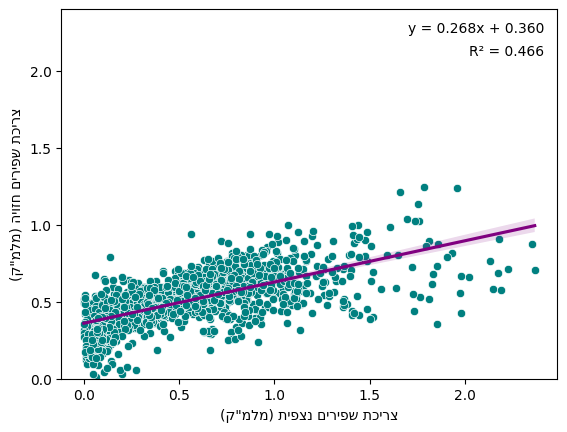

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

plot_data = my_df1[['w1+w2+w3', 'predicted_w']].reset_index(drop=True)
plot_data['wf_observed_in_milions'] = plot_data['w1+w2+w3'] / 1000
plot_data['wf_expected_in_milions'] = plot_data['predicted_w'] / 1000

slope, intercept, r_value, _, _ = linregress(plot_data['wf_observed_in_milions'], plot_data['wf_expected_in_milions'])

sns.scatterplot(data=plot_data, x='wf_observed_in_milions', y='wf_expected_in_milions', color='teal')

sns.regplot(data=plot_data, x='wf_observed_in_milions', y='wf_expected_in_milions', scatter=False, color='purple')

r_squared = r_value ** 2
plt.text(2.02, 2.1, f'R² = {r_squared:.3f}', color='black')

equation_text = f'y = {slope:.3f}x + {intercept:.3f}'
plt.text(1.7, 2.25, equation_text, color='black')

xlab_f = 'צריכת שפירים נצפית )מלמ"ק('
ylab_f = 'צריכת שפירים חזויה )מלמ"ק('
plt.ylim(0, 2.4)

plt.xlabel(xlab_f[::-1])
plt.ylabel(ylab_f[::-1])

plt.show()

In [14]:
s_base_exog_vars = ['ps','quota_s']
s_expelantories = ['Season Avg Temp (May-Sept)','Preseason Perc (April-May)','Postseason Perc (September-October)','trend','quota_t']
additional_vars_list = ['FWBS1','sqr_dps', 'qs_dFWBS']

mydata_s = df[df['consumertype'] != 'FW']

my_df2 = mydata_s.set_index(['consumernumber', 'year'])

Y = my_df2['ws']
X = my_df2[s_base_exog_vars + additional_vars_list + 
            [var for var in s_expelantories if var != 'shafdan_access']]
# Add a constant (intercept) to the model
X = sm.add_constant(X)
# Estimate fixed effects model
s_mod_fe = PanelOLS(Y, X, 
                    entity_effects=True)  # entity_effects=True for fixed effects

# Fit the model with clustered standard errors
s_results = s_mod_fe.fit(cov_type='clustered', 
                        cluster_entity=True)

my_df2['predicted_ws'] = s_results.predict(X)
my_df2 = my_df2.dropna(subset=['ws', 'predicted_ws'])


c:\Users\saarp\AppData\Local\Programs\Python\Python311\Lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


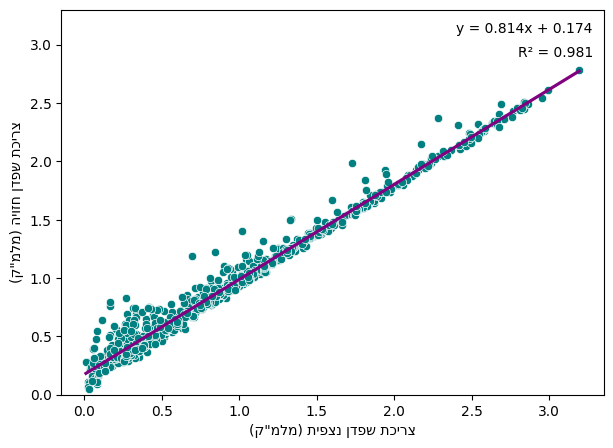

In [15]:
plot_data_s = my_df2[['ws', 'predicted_ws']].reset_index(drop=True)
plot_data_s['ws_observed_in_milions'] = plot_data_s['ws'] / 1000
plot_data_s['ws_expected_in_milions'] = plot_data_s['predicted_ws'] / 1000


slope, intercept, r_value, _, _ = linregress(
    plot_data_s['ws_observed_in_milions'], plot_data_s['ws_expected_in_milions']
)

plt.figure(figsize=(7, 5))
sns.scatterplot(data=plot_data_s, x='ws_observed_in_milions', y='ws_expected_in_milions', color='teal')

sns.regplot(data=plot_data_s, x='ws_observed_in_milions', y='ws_expected_in_milions', scatter=False, color='purple')

r_squared = r_value**2
r = plot_data_s['ws_observed_in_milions'].corr(plot_data_s['ws_expected_in_milions'])

plt.text(2.8, 2.9, f'R² = {r_squared:.3f}', color='black')

# הצגת משוואת הרגרסיה
equation_text = f'y = {slope:.3f}x + {intercept:.3f}'
plt.text(2.4, 3.1, equation_text, color='black')

xlab_s = 'צריכת שפדן נצפית )מלמ"ק('

ylab_s = 'צריכת שפדן חזויה )מלמ"ק('
plt.ylim(0, 3.3)

plt.xlabel(xlab_s[::-1])
plt.ylabel(ylab_s[::-1])

plt.show()

#### Functions

In [16]:
def fited_D_func(demand_func, b, dig=12):

    Con = sp.symbols('Const')
    
    alpha0,alpha1, alpha2, alpha3 = sp.symbols('alpha0 alpha1 alpha2 alpha3')
    beta0, beta1, beta2, beta3, beta4, beta5 = sp.symbols('beta0 beta1 beta2 beta3 beta4 beta5')
    beta10, beta11, beta12, beta13, beta14, beta15 = sp.symbols('beta10 beta11 beta12 beta13 beta14 beta15')
    beta20, beta21, beta22, beta23, beta24, beta25 = sp.symbols('beta20 beta21 beta22 beta23 beta24 beta25')
    gamma1, gamma2, gamma3, gamma4,gamma5,gamma6 = sp.symbols('gamma1 gamma2 gamma3 gamma4 gamma5 gamma6')
    Demand_eq_tag = demand_func
    parameter_values2 = {
                        Con: round(float(b.params['const']) if 'const' in b.params and b.pvalues['const'] < 0.1 else 0, dig),
                        alpha0: round(float(b.params['pf1']) if 'pf1' in b.params and b.pvalues['pf1'] < 0.1 else 0, dig),
                        alpha1: round(float(b.params['ps']) if 'ps' in b.params and b.pvalues['ps'] < 0.1 else 0, dig),
                        alpha2: round(float(b.params['q1']) if 'q1' in b.params and b.pvalues['q1'] < 0.1 else 0, dig),
                        alpha3: round(float(b.params['quota_s']) if 'quota_s' in b.params and b.pvalues['quota_s'] < 0.1 else 0, dig),
    #                       ======================================================================================================================
                        beta0: round(float(b.params['FWBS1']) if 'FWBS1' in b.params and b.pvalues['FWBS1'] < 0.1 else 0, dig),
                        beta1: round(float(b.params['sqr_dps']) if 'sqr_dps' in b.params and b.pvalues['sqr_dps'] < 0.1 else 0, dig),
                        beta2: round(float(b.params['qs_dFWBS']) if 'qs_dFWBS' in b.params and b.pvalues['qs_dFWBS'] < 0.1 else 0, dig),
                        # beta4: round(float(b.params['nT x FWBS1']) if 'nT x FWBS1' in b.params and b.pvalues['nT x FWBS1'] < 0.1 else 0, dig),
                        # beta5: round(float(b.params['nT x delta_FWBS']) if 'nT x delta_FWBS' in b.params and b.pvalues['nT x delta_FWBS'] < 0.1 else 0, dig),
    #                       ======================================================================================================================
                        # beta11: round(float(b.params['FWBS1']) if 'FWBS1' in b.params and b.pvalues['FWBS1'] < 0.1 else 0, dig),
                        beta11: round(float(b.params['q_delta_BS_fw']) if 'q_delta_BS_fw' in b.params and b.pvalues['q_delta_BS_fw'] < 0.1 else 0, dig),
                        beta12: round(float(b.params['S x FWBS2']) if 'S x FWBS2' in b.params and b.pvalues['S x FWBS2'] < 0.1 else 0, dig),
    #                       ======================================================================================================================
                        gamma1: round(float(b.params['Season Avg Temp (May-Sept)']) if 'Season Avg Temp (May-Sept)' in b.params and b.pvalues['Season Avg Temp (May-Sept)'] < 0.1 else 0, dig),
                        gamma2: round(float(b.params['Preseason Perc (April-May)']) if 'Preseason Perc (April-May)' in b.params and b.pvalues['Preseason Perc (April-May)'] < 0.1 else 0, dig),
                        gamma3: round(float(b.params['Postseason Perc (September-October)']) if 'Postseason Perc (September-October)' in b.params and b.pvalues['Postseason Perc (September-October)'] < 0.1 else 0, dig),
                        gamma5: round(float(b.params['trend']) if 'trend' in b.params and b.pvalues['trend'] < 0.1 else 0, dig),
                        gamma6: round(float(b.params['quota_t']) if 'quota_t' in b.params and b.pvalues['quota_t'] < 0.1 else 0, dig),
                            }

    inverse_Demand_eq_tag = Demand_eq_tag.subs(parameter_values2)
    # print(inverse_Demand_eq_tag)
    return inverse_Demand_eq_tag

def parameters_D_func():
    #setting parameters
    wf, p_s,p_f1, p_f2, p_f3, q1, q2, qs, qt, Con, k, m ,a = sp.symbols('w_f p_s p_f1 p_f2 p_f3 q1 q2 q_s q_t Const k m a')
    # fwbs1, dps = sp.symbols('fwbs1 sqr_dps')
    preperc, seaperc, temp,shaf_a,tikun, tww_a, trend = sp.symbols('preperc seaperc temp shaf_a tikun tww_a trend')
    alpha0,alpha1, alpha2, alpha3 = sp.symbols('alpha0 alpha1 alpha2 alpha3')
    beta0, beta1, beta2, beta3, beta4, beta5 = sp.symbols('beta0 beta1 beta2 beta3 beta4 beta5')
    beta10, beta11, beta12, beta13, beta14, beta15 = sp.symbols('beta10 beta11 beta12 beta13 beta14 beta15')
    beta20, beta21, beta22, beta23, beta24, beta25 = sp.symbols('beta20 beta21 beta22 beta23 beta24 beta25')
    gamma1, gamma2, gamma3, gamma4,gamma5, gamma6 = sp.symbols('gamma1 gamma2 gamma3 gamma4 gamma5 gamma6')

    FWBS1 = (q1) * (p_f2 - p_f1)
    FWBS2 = FWBS1 + (q1+q2) * (p_f3 - p_f2)
    # Define tag differential terms
    BS_s = qs * (p_f1 - p_s)
    BS_1 = BS_s + (qs) * (p_f2 - p_f1) + FWBS1
    BS_2 = (p_f1 - p_s) * qs + (p_f2 - p_f1) * (q1+qs) + (p_f3 - p_f2) * (q1+q2+qs)
    sqr_BSS = (BS_s)**2

    delta_FWBS = (FWBS1 - FWBS2)
    sqr_dps = (p_s - p_f1)**2
    delta_pf = (p_f1 - p_f2)
    q_delta_BS_fw = (q1) * (BS_1 - BS_2)
    delta_pf_tag = (p_f1 - p_f3)


    
    w_hat_base = Con + (alpha0 * p_f1) + (alpha1 * p_s) + (alpha2 * q1) + (alpha3 * qs) 
    w_hat_exp = (gamma1*temp) + (gamma2 * preperc) + (gamma3 * seaperc) + (gamma5 * trend) + (gamma6 * qt)
    w_hat_shafd = (beta0* FWBS1) + (beta1 * sqr_dps) + (beta2 * delta_FWBS * qs) 
    w_hat_fw = (beta11 * q_delta_BS_fw) +(beta12 * FWBS2 * shaf_a)
    w_hat_s2 = w_hat_base + w_hat_exp + w_hat_shafd + w_hat_fw
    w_hat_simplified_s2 = sp.simplify(w_hat_s2)

    prices_definition = {q2: a*q1}
    # #p_f2: k*p_f1, p_f3: m*p_f1,}
    w_hat_simplified_s22 = w_hat_simplified_s2.subs(prices_definition)
    w_hat_simplified_s22 = sp.simplify(w_hat_simplified_s22)

    return w_hat_simplified_s22

def parameters_D_func_fwbs():
    #setting parameters
    wf, p_s,p_f1, p_f2, p_f3, q1, q2, qs, qt, Con, k, m ,a = sp.symbols('w_f p_s p_f1 p_f2 p_f3 q1 q2 q_s q_t Const k m a')
    fwbs1, dps = sp.symbols('fwbs1 sqr_dps')
    preperc, seaperc, temp,shaf_a,tikun, tww_a, trend = sp.symbols('preperc seaperc temp shaf_a tikun tww_a trend')
    alpha0,alpha1, alpha2, alpha3 = sp.symbols('alpha0 alpha1 alpha2 alpha3')
    beta0, beta1, beta2, beta3, beta4, beta5 = sp.symbols('beta0 beta1 beta2 beta3 beta4 beta5')
    beta10, beta11, beta12, beta13, beta14, beta15 = sp.symbols('beta10 beta11 beta12 beta13 beta14 beta15')
    beta20, beta21, beta22, beta23, beta24, beta25 = sp.symbols('beta20 beta21 beta22 beta23 beta24 beta25')
    gamma1, gamma2, gamma3, gamma4,gamma5, gamma6 = sp.symbols('gamma1 gamma2 gamma3 gamma4 gamma5 gamma6')


    # Define tag differential terms
    BS_s = qs * (p_f1 - p_s)
    BS_1 = BS_s + (qs) * (p_f2 - p_f1) + fwbs1
    BS_2 = (p_f1 - p_s) * qs + (p_f2 - p_f1) * (q1+qs) + (p_f3 - p_f2) * (q1+q2+qs)
    sqr_BSS = (BS_s)**2
    # FWBS1 = (q1) * (p_f2 - p_f1)
    FWBS2 = fwbs1 + (q1+q2) * (p_f3 - p_f2)
    delta_FWBS = (fwbs1 - FWBS2)
    # sqr_dps = (p_s - p_f1)**2
    delta_pf = (p_f1 - p_f2)
    q_delta_BS_fw = (q1) * (BS_1 - BS_2)
    delta_pf_tag = (p_f1 - p_f3)


    
    w_hat_base = Con + (alpha0 * p_f1) + (alpha1 * p_s) + (alpha2 * q1) + (alpha3 * qs) 
    w_hat_exp = (gamma1*temp) + (gamma2 * preperc) + (gamma3 * seaperc) + (gamma5 * trend) + (gamma6 * qt)
    w_hat_shafd = (beta0* fwbs1) + (beta1 * dps**2) + (beta2 * delta_FWBS * qs) 
    w_hat_fw = (beta11 * q_delta_BS_fw) +(beta12 * FWBS2 * shaf_a)
    w_hat_s2 = w_hat_base + w_hat_exp + w_hat_shafd + w_hat_fw
    w_hat_simplified_s2 = sp.simplify(w_hat_s2)

    prices_definition = {q2: a*q1}
    # #p_f2: k*p_f1, p_f3: m*p_f1,}
    w_hat_simplified_s22 = w_hat_simplified_s2.subs(prices_definition)
    w_hat_simplified_s22 = sp.simplify(w_hat_simplified_s22)

    return w_hat_simplified_s22


In [206]:
s = fited_D_func(parameters_D_func(), sfe_results)
s

-103.088100329613*p_s - 1.051734002909*preperc - 0.02094781695*q1*(p_f1 - p_f2) + 0.819250941054*q_s - 0.034406264973*q_t + 1.038263632158*seaperc + 61.622875422895*temp + 16.389084669836*trend + 48.952466404249*(p_f1 - p_s)**2 - 1454.39639067548

### Shafdan simalutions

In [20]:
coeff_vector = [-1454.396,
                -103.088,
                0.819,-0.0344,
                -1.052,1.038,61.623,
                16.389,
                -0.021,48.952]

mydata_s_2020 = mydata_s[mydata_s['year'] == 2020]

q1dpf = mydata_s_2020['q1'].mean() * (mydata_s_2020['pf2'].mean() - mydata_s_2020['pf1'].mean())
q1 = mydata_s_2020['q1'].mean()
preperc = mydata_s_2020['Preseason Perc (April-May)'].mean()
seaperc = mydata_s_2020['Postseason Perc (September-October)'].mean()
temp = mydata_s_2020['Season Avg Temp (May-Sept)'].mean()
trend = mydata_s_2020['trend'].mean()
quota_s = mydata_s_2020['quota_s'].mean()
quota_t = mydata_s_2020['quota_t'].mean()
p_s = mydata_s_2020['ps'].mean()
dps = (mydata_s_2020['pf1'].mean() - mydata_s_2020['ps'].mean())**2


In [21]:
# checking the values :

print(f'q1dpf: {q1dpf}')
print(f'q1: {q1}')
print(f'preperc: {preperc}')
print(f'seaperc: {seaperc}')
print(f'temp: {temp}')
print(f'trend: {trend}')
print(f'quota_s: {quota_s}')
print(f'quota_t: {quota_t}')
print(f'p_s: {p_s}')
print(f'dps: {dps}')


q1dpf: 1203.7955572154342
q1: 844.1641157024794
preperc: 22.456555977875254
seaperc: 0.08095347862871159
temp: 26.131495431722897
trend: 5.0
quota_s: 1067.312347107438
quota_t: 373.8325289256199
p_s: 1.31215413
dps: 0.24459194375476578


In [22]:
print(f"2050 increase: {(293.6/175.4):.2f}")
print(f"2040 increase: {(251.9/175.4):.2f}")
print(f"2030 increase: {(216.2/175.4):.2f}")

2050 increase: 1.67
2040 increase: 1.44
2030 increase: 1.23


### For Simulations Table

In [138]:

trend_list = [5, 15, 25, 35]
initial_param_vector = [p_s,quota_s, quota_t, preperc, seaperc, temp]
last_param_vector = [q1dpf, dps]
for t in trend_list:
    param_vector = initial_param_vector + [t] + last_param_vector
    eq = np.dot(coeff_vector[1:], param_vector) + coeff_vector[0]
    total_demand = eq*raw[raw['previouscode']>4]['consumernumber'].nunique()/1000
    print(f'Year: {t+2015}, Total Consumption: {total_demand:.1f} MCM')

print("==="*20)
# quotas increase

quota_s_list = [quota_s,
                 quota_s*1.10,
                   quota_s*1.25,
                     quota_s*1.50]

initial_param_vector1 = [p_s]
last_param_vector1 = [quota_t, preperc, seaperc, temp, trend, q1dpf, dps]
for qs in quota_s_list:
    param_vector = initial_param_vector1 + [qs] + last_param_vector1
    eq1 = np.dot(coeff_vector[1:], param_vector) + coeff_vector[0]
    total_demand1 = eq1*raw[raw['previouscode']>4]['consumernumber'].nunique()/1000
    print(f'avg Quota S: {qs:.2f}, Total Consumption: {total_demand1:.1f} MCM')

print("==="*20)
# Temperature increase

temp_list = [temp,
              temp+0.5,
                temp+1,
                    temp+2,
                      ]

initial_param_vector2 = [p_s,quota_s, quota_t, preperc, seaperc]
last_param_vector2 = [trend,q1dpf, dps]
for temp1 in temp_list:
    param_vector = initial_param_vector2 + [temp1] + last_param_vector2
    eq2 = np.dot(coeff_vector[1:], param_vector) + coeff_vector[0]
    total_demand2 = eq2*raw[raw['previouscode']>4]['consumernumber'].nunique()/1000
    print(f'avg Temp for Irrigation Season: {temp1:.2f} Celius, Total Consumption: {total_demand2:.1f} MCM')

print("==="*20)


preperc_list = [preperc*1.2,
                preperc,
                preperc*0.8,
                  preperc*0.6,
                    ]
initial_param_vector3 = [p_s,quota_s, quota_t]
last_param_vector3 = [seaperc, temp, trend, q1dpf, dps ]

for preperc1 in preperc_list:
    param_vector = initial_param_vector3 + [preperc1] + last_param_vector3
    eq3 = np.dot(coeff_vector[1:], param_vector) + coeff_vector[0]
    total_demand3 = eq3*raw[raw['previouscode']>4]['consumernumber'].nunique()/1000
    print(f'Preseason Percipitation: {preperc1:.2f}mm, Total Consumption: {total_demand3:.1f} MCM')



#fullscenariofor2050demand
param_vector2050 = [p_s,quota_s*1.25, quota_t, preperc*0.8,seaperc, temp+2, trend+35, q1dpf, dps]
eq4 = np.dot(coeff_vector[1:], param_vector2050) + coeff_vector[0]
total_demand4 = eq4*raw[raw['previouscode']>4]['consumernumber'].nunique()/1000
print("==="*20)
print(f'2050 Total Consumption : {total_demand4:.1f} MCM')
print(f'In 2050 Avg Daily Temp is: {(temp+2):.2f} Celious')
print(f'In 2050 Preseason Percipitation forecast: {(preperc*0.8):.2f} mm')
print(f'In 2050 "Trend" is: {trend+35}')
print(f'In 2050 mean QuotaS increasing based on Supply to: {quota_s*1.25:.2f} TCM')




Year: 2020, Total Consumption: 126.1 MCM
Year: 2030, Total Consumption: 148.4 MCM
Year: 2040, Total Consumption: 170.7 MCM
Year: 2050, Total Consumption: 192.9 MCM
avg Quota S: 1067.31, Total Consumption: 126.1 MCM
avg Quota S: 1174.04, Total Consumption: 138.0 MCM
avg Quota S: 1334.14, Total Consumption: 155.8 MCM
avg Quota S: 1600.97, Total Consumption: 185.5 MCM
avg Temp for Irrigation Season: 26.13 Celius, Total Consumption: 126.1 MCM
avg Temp for Irrigation Season: 26.63 Celius, Total Consumption: 130.3 MCM
avg Temp for Irrigation Season: 27.13 Celius, Total Consumption: 134.5 MCM
avg Temp for Irrigation Season: 28.13 Celius, Total Consumption: 142.8 MCM
Preseason Percipitation: 26.95mm, Total Consumption: 125.4 MCM
Preseason Percipitation: 22.46mm, Total Consumption: 126.1 MCM
Preseason Percipitation: 17.97mm, Total Consumption: 126.7 MCM
Preseason Percipitation: 13.47mm, Total Consumption: 127.4 MCM
2050 Total Consumption : 251.2 MCM
In 2050 Avg Daily Temp is: 28.13 Celious
In 2

In [198]:
(raw[raw['year']==2020]['pf2_jul'].mean() + raw[raw['year']==2020]['pf2_jan'].mean())/2

3.1320195625297744

### Pricing Simulations

In [199]:
specific_coeff_vector = [-1454.396,
                0.819,-0.0344,
                -1.052,1.038,61.623,
                16.389]

preperc = mydata_s_2020['Preseason Perc (April-May)'].mean()
seaperc = mydata_s_2020['Postseason Perc (September-October)'].mean()
temp = mydata_s_2020['Season Avg Temp (May-Sept)'].mean()
trend = mydata_s_2020['trend'].mean()
quota_s = mydata_s_2020['quota_s'].mean()
quota_t = mydata_s_2020['quota_t'].mean()

controlled_param = [quota_s, quota_t, preperc, seaperc, temp, trend]
myconst = np.dot(specific_coeff_vector[1:], controlled_param) + specific_coeff_vector[0]
#-103.088,
#-0.021,
#48.952
ps_array = np.arange(0.8, 3.02, 0.02)
pf1_array = np.arange(1.5, 3.02, 0.02)

val_list = []
for ps in ps_array:
    for pf1 in pf1_array:
        if ps <= pf1:
            q1dpf = mydata_s_2020['q1'].mean()*(3.1-pf1)
            price_impact = -103.088*ps -0.021*q1dpf + 48.952*(pf1-ps)**2
            consumption = myconst + price_impact
            l = [ps, pf1, consumption]
            
        # else:
        #     consumption = 0
        #     l = [ps, pf1, consumption]
        val_list.append(l)

prices_scenarios = pd.DataFrame(val_list, columns=['ps', 'pf1', 's_cons'])
prices_scenarios['Total Consumption (MCM)'] = prices_scenarios['s_cons'] * raw[raw['previouscode']>4]['consumernumber'].nunique() / 1000


In [219]:
val_list1=[]
pf1_senarios = [1.81, 1.5, 2.1]
ps_array1 = np.arange(0.75, 2.5, 0.01)
for ps in ps_array1:
    l=[]
    for pf1 in pf1_senarios:
        if ps <= pf1:
            q1dpf = mydata_s_2020['q1'].mean()*(3.5-pf1)
            price_impact = -103.088*ps -0.021*q1dpf + 48.952*(pf1-ps)**2
            consumption = (myconst + price_impact) * raw[raw['previouscode']>4]['consumernumber'].nunique() / 1000
            l.append(consumption)
        else:
            l.append(np.nan)
    val_list1.append(l)

prices_scenarios1 = pd.DataFrame(val_list1, columns=['pf1 = 1.81', 'pf1 = 1.50', 'pf1 = 2.10'])
prices_scenarios1['ps'] = ps_array1

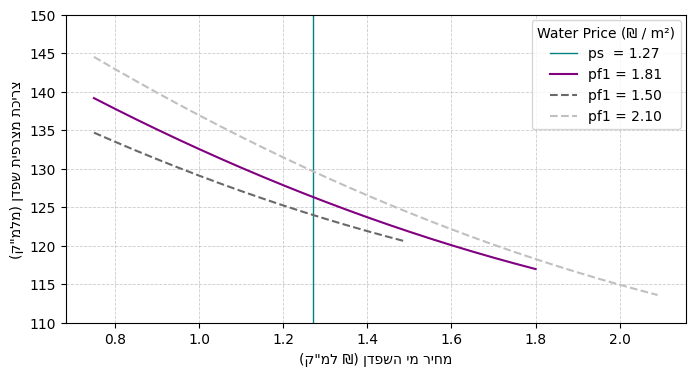

In [221]:
plt.style.use('default')
purple_shades = ['purple', 'dimgray' , 'silver']
fig, ax = plt.subplots(figsize=(8, 4))

shafdan_price = ((raw[raw['year']==2020]['ps_jul'].mean() + raw[raw['year']==2020]['ps_jan'].mean())/2).round(2)
ax.axvline(x=shafdan_price, color='teal', linewidth=1, alpha=1, label = f'ps  = {shafdan_price:.2f}')

for i, col in enumerate(prices_scenarios1.columns[:-1]):
    # i want to add condition that if col!="2.0" than the line would be "---" and else full line
    if col == 'pf1 = 1.81':
        ax.plot(prices_scenarios1['ps'], prices_scenarios1[col], label=col, color=purple_shades[i])
    else:
        ax.plot(prices_scenarios1['ps'], prices_scenarios1[col], label=col, color=purple_shades[i], linestyle='--')

xlab1 = 'מחיר מי השפדן )₪ למ"ק('
ylab1 = 'צריכת מצרפית שפדן )מלמ"ק('
ax.set_xlabel(xlab1[::-1])
ax.set_ylabel(ylab1[::-1])

leg1 = 'Water Price (₪ / m²)'
ax.legend(title= leg1, loc='upper left', bbox_to_anchor=(0.74, 1.005))
yticks = np.arange(110, 155, 5)
ax.set_yticks(yticks
)
# Show plot
ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.8, color='silver')
plt.show()

### Welfare - Shafdan

In [24]:
s = fited_D_func(parameters_D_func(), sfe_results)
s

-103.088100329613*p_s - 1.051734002909*preperc - 0.02094781695*q1*(p_f1 - p_f2) + 0.819250941054*q_s - 0.034406264973*q_t + 1.038263632158*seaperc + 61.622875422895*temp + 16.389084669836*trend + 48.952466404249*(p_f1 - p_s)**2 - 1454.39639067548

In [48]:
def constant_for_parameters(parameters_dfunc_list, ps_coeff = -103.088):
    # ps_array = np.arange(1, 2.001, 0.01)
    coeffs_dfunc_list = [
        1/ps_coeff * 1454.396 ,
        1/ps_coeff * -0.819,
        1/ps_coeff * 0.0344,
        1/ps_coeff * -61.623,
        1/ps_coeff * -1.0383,
        1/ps_coeff * 1.0517,
        1/ps_coeff * -16.389,
        1/ps_coeff * 0.0209,
        1/ps_coeff * -48.952]

        # dps = (pf1 - ps)**2
        # dps_to_eq_addon = 1/ps_coeff * 48.952 * dps
    const_dfunc = np.dot(parameters_dfunc_list, coeffs_dfunc_list[1:]) + coeffs_dfunc_list[0]
    ps_coeff_fixed = sp.simplify(1/ps_coeff)
    return const_dfunc, ps_coeff_fixed





mydata_s_2020 = mydata_s[mydata_s['year'] == 2020]
q1dpf = mydata_s_2020['q1'].mean() * (mydata_s_2020['pf2'].mean() - mydata_s_2020['pf1'].mean())
preperc = mydata_s_2020['Preseason Perc (April-May)'].mean()
seaperc = mydata_s_2020['Postseason Perc (September-October)'].mean()
temp = mydata_s_2020['Season Avg Temp (May-Sept)'].mean()
trend = mydata_s_2020['trend'].mean()
quota_s = mydata_s_2020['quota_s'].mean()
quota_t = mydata_s_2020['quota_t'].mean()
p_s = mydata_s_2020['ps'].mean()
dps = (mydata_s_2020['pf1'].mean() - mydata_s_2020['ps'].mean())**2

parameters_dfunc_list_2020 = [quota_s, quota_t, preperc,seaperc, temp, trend,q1dpf,dps]
parameters_dfunc_list_2050 = [quota_s*1.67, quota_t, preperc*0.8,seaperc, temp+2, trend+35,q1dpf,dps]

const_dfunc_2020, ps_coeff_fixed_2020 = constant_for_parameters(parameters_dfunc_list_2020, ps_coeff = -103.088)
print(f'Constat for 2020: {const_dfunc_2020:.4f} , Coeff: {ps_coeff_fixed_2020:.4f}')
const_dfunc_2050, ps_coeff_fixed_2050 = constant_for_parameters(parameters_dfunc_list_2050, ps_coeff = -103.088)
print(f'Constat for 2050: {const_dfunc_2050:.4f} , Coeff: {ps_coeff_fixed_2050:.4f}')




Constat for 2020: 8.0715 , Coeff: -0.0097
Constat for 2050: 16.6119 , Coeff: -0.0097


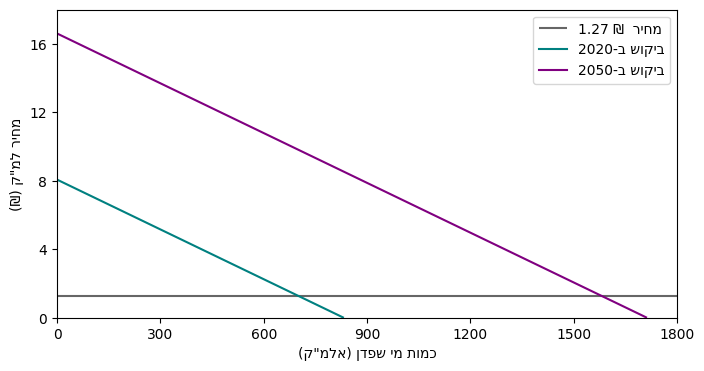

In [202]:
import numpy as np
import matplotlib.pyplot as plt

ws = np.arange(0, 3010, 10)

vmp_2020_array = const_dfunc_2020 + ps_coeff_fixed_2020 * ws
valid_idx_2020 = vmp_2020_array >= 0
ws_2020 = ws[valid_idx_2020]
vmp_2020_array = vmp_2020_array[valid_idx_2020]

vmp_2050_array = const_dfunc_2050 + ps_coeff_fixed_2050 * ws
valid_idx_2050 = vmp_2050_array >= 0
ws_2050 = ws[valid_idx_2050]
vmp_2050_array = vmp_2050_array[valid_idx_2050]

plt.style.use('default')

fig, ax = plt.subplots(figsize=(8, 4))

price_lab = f'מחיר '
p_s1 = (raw[raw['year']==2020]['ps_jan'].mean()+raw[raw['year']==2020]['ps_jul'].mean())/2
ax.hlines(p_s1, 0, 3000, color='black', alpha=0.6, label=f'{p_s1:.2f} ₪ ' + price_lab[::-1])
lab2020 = 'ביקוש ב-0202'
ax.plot(ws_2020, vmp_2020_array, label=lab2020[::-1], color='teal')
lab2050 = 'ביקוש ב-0502'
ax.plot(ws_2050, vmp_2050_array, label=lab2050[::-1], color='purple')
p_s = mydata_s_2020['ps'].mean()

ax.set_xlim(0, 1800)
ax.set_ylim(0, 18)

x_lab = 'כמות מי שפדן )אלמ"ק('
y_lab = 'מחיר למ"ק )₪('

ax.set_xlabel(x_lab[::-1])
ax.set_ylabel(y_lab[::-1])

ax.set_xticks(np.arange(0, 1801, 300))
ax.set_yticks(np.arange(0, 18, 4))

ax.legend()
plt.show()


-0.00970045010088468

In [204]:
# p_s1 = const_dfunc_2020 + ps_coeff_fixed_2020 * ws
ws1_tofind = (p_s1 - const_dfunc_2020) / (ps_coeff_fixed_2020)
ws2_tofind = (p_s1 - const_dfunc_2050) / (ps_coeff_fixed_2050)

print(f'Water Supply for 2020: {ws1_tofind:.2f} TCM')
print(f'Water Supply for 2050: {ws2_tofind:.2f} TCM')


little_t_area = ((const_dfunc_2020-p_s1) * ws1_tofind * 1000)/2
print(f'Little Triangle Area: {little_t_area:.0f}')

big_t_area = ((const_dfunc_2050-p_s1) * ws2_tofind * 1000)/2
print(f'Big Triangle Area: {big_t_area:.0f}')

cs_diff = big_t_area - little_t_area
print(f'Mean Consumer Surplus Added: {cs_diff:.0f}')
total_cs_diff = raw[raw['previouscode']>4]['consumernumber'].nunique() * cs_diff
print(f'Total Consumer Surplus Added: {total_cs_diff:.0f}')

Water Supply for 2020: 701.02 TCM
Water Supply for 2050: 1581.43 TCM
Little Triangle Area: 2383547
Big Triangle Area: 12130039
Mean Consumer Surplus Added: 9746492
Total Consumer Surplus Added: 1325522894


In [109]:
raw[raw['previouscode']>4]['consumernumber'].nunique()

136

#### Welfare - FW

In [207]:
fw = fited_D_func(parameters_D_func(), ffe_results)
fw

-192.623820492141*p_f1 - 3.68918145332*preperc + 0.035683588922*q1*shaf_a*(p_f1 - p_f2 + (a + 1)*(p_f2 - p_f3)) - 2.641843e-5*q1*(q1*(p_f1 - p_f2) + q_s*(p_f1 - p_f2) - (p_f1 - p_f2)*(q1 + q_s) - (p_f2 - p_f3)*(a*q1 + q1 + q_s)) + 0.472155530176*q1 + 312.09853847906*temp - 16.110648555045*trend - 7327.86922952096

In [212]:
mydata_s_2020 = mydata_s[mydata_s['year'] == 2020]
preperc = mydata_s_2020['Preseason Perc (April-May)'].mean()
seaperc = mydata_s_2020['Postseason Perc (September-October)'].mean()
temp = mydata_s_2020['Season Avg Temp (May-Sept)'].mean()
trend = mydata_s_2020['trend'].mean()
quota_s = mydata_s_2020['quota_s'].mean()
quota_t = mydata_s_2020['quota_t'].mean()


p_s = mydata_s_2020['ps'].mean()


dps = (mydata_s_2020['pf1'].mean() - mydata_s_2020['ps'].mean())**2
q1dpf = mydata_s_2020['q1'].mean() * (mydata_s_2020['pf2'].mean() - mydata_s_2020['pf1'].mean())


q1 = mydata_s_2020['q1'].mean()
p_f1 = mydata_s_2020['pf1'].mean()

s1 = q1 * 1 * ((p_f1 - 3.1) + 1.1*(3.10 - 5.94))
s2 = q1 * (q1*(p_f1 - 3.1) + quota_s*(p_f1 - 3.10) - (q1 + quota_s)*(p_f1 - 3.10) - (1.1*q1 + quota_s)*(3.10 - 5.94))


In [214]:
def constant_for_parameters_fw(parameters_dfunc_list_fw, pf1_coeff = -192.6238):

    coeffs_dfunc_list_fw = [
        1/pf1_coeff * 7327.869 , #const
        1/pf1_coeff * -0.4722, # q1
        1/pf1_coeff * 3.6892, # preperc
        1/pf1_coeff * -312.09854, #temp
        1/pf1_coeff * 16.1106, #trend

        1/pf1_coeff * -0.03568, # s1
        1/pf1_coeff * 2.641843 * 10**-5, # s2
    ]

    const_dfunc_fw = np.dot(parameters_dfunc_list_fw, coeffs_dfunc_list_fw[1:]) + coeffs_dfunc_list_fw[0]
    pf1_coeff_fixed = sp.simplify(1/pf1_coeff)
    return const_dfunc_fw, pf1_coeff_fixed




mydata_s_2020 = mydata_s[mydata_s['year'] == 2020]
preperc = mydata_s_2020['Preseason Perc (April-May)'].mean()
temp = mydata_s_2020['Season Avg Temp (May-Sept)'].mean()
trend = mydata_s_2020['trend'].mean()
quota_s = mydata_s_2020['quota_s'].mean()
q1 = mydata_s_2020['q1'].mean()
p_f1 = mydata_s_2020['pf1'].mean()

s1 = q1 * 1 * ((p_f1 - 3.1) + 1.1*(3.10 - 5.94))
s2 = q1 * (q1*(p_f1 - 3.1) + quota_s*(p_f1 - 3.10) - (q1 + quota_s)*(p_f1 - 3.10) - (1.1*q1 + quota_s)*(3.10 - 5.94))

parameters_dfunc_list_2020_fw = [q1, preperc, temp, trend,s1,s2]
parameters_dfunc_list_2050_fw = [q1, preperc*0.8, temp+2, trend+35,s1,s2]

const_dfunc_2020_fw, pf1_coeff_fixed_2020_fw = constant_for_parameters_fw(parameters_dfunc_list_2020_fw, pf1_coeff = -192.6238)
print(f'Constat for 2020: {const_dfunc_2020_fw:.4f} , Coeff: {pf1_coeff_fixed_2020_fw:.4f}')

const_dfunc_2050_fw, pf1_coeff_fixed_2050_fw = constant_for_parameters_fw(parameters_dfunc_list_2050_fw, pf1_coeff = -192.6238)
print(f'Constat for 2050: {const_dfunc_2050_fw:.4f} , Coeff: {pf1_coeff_fixed_2050_fw:.4f}')



Constat for 2020: 4.1713 , Coeff: -0.0052
Constat for 2050: 4.5705 , Coeff: -0.0052


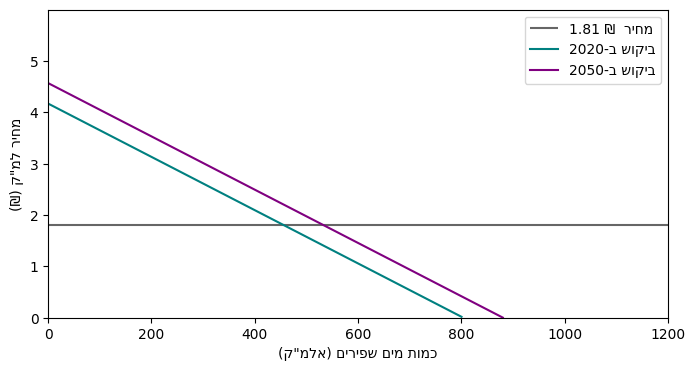

In [ ]:
wf = np.arange(0, 3010, 10)

vmp_2020_array_fw = const_dfunc_2020_fw + pf1_coeff_fixed_2020_fw * wf
valid_idx_2020_fw = vmp_2020_array_fw >= 0
wf_2020 = wf[valid_idx_2020_fw]
vmp_2020_array_fw = vmp_2020_array_fw[valid_idx_2020_fw]

vmp_2050_array_fw = const_dfunc_2050_fw + pf1_coeff_fixed_2050_fw * wf
valid_idx_2050_fw = vmp_2050_array_fw >= 0
wf_2050 = wf[valid_idx_2050_fw]
vmp_2050_array_fw = vmp_2050_array_fw[valid_idx_2050_fw]

plt.style.use('default')

fig, ax = plt.subplots(figsize=(8, 4))

price_lab = f'מחיר '
p_f1_raw = (raw[raw['year']==2020]['pf1_jan'].mean()+raw[raw['year']==2020]['pf1_jul'].mean())/2
ax.hlines(p_f1, 0, 3000, color='black', alpha=0.6, label=f'{p_f1:.2f} ₪ ' + price_lab[::-1])
lab2020 = 'ביקוש ב-0202'
ax.plot(wf_2020, vmp_2020_array_fw, label=lab2020[::-1], color='teal')
lab2050 = 'ביקוש ב-0502'
ax.plot(wf_2050, vmp_2050_array_fw, label=lab2050[::-1], color='purple')

ax.set_xlim(0, 1200)
ax.set_ylim(0, 6)

x_lab = 'כמות מים שפירים )אלמ"ק('
y_lab = 'מחיר למ"ק )₪('

ax.set_xlabel(x_lab[::-1])
ax.set_ylabel(y_lab[::-1])

ax.set_xticks(np.arange(0, 1201, 200))
ax.set_yticks(np.arange(0, 6, 1))

ax.legend()
plt.show()


In [223]:
wf1_tofind = (p_f1_raw - const_dfunc_2020_fw) / (pf1_coeff_fixed_2020_fw)
wf2_tofind = (p_f1_raw - const_dfunc_2050_fw) / (pf1_coeff_fixed_2050_fw)

print(f'Water Supply for 2020: {wf1_tofind:.2f} TCM')
print(f'Water Supply for 2050: {wf2_tofind:.2f} TCM')

little_t_area_fw = ((const_dfunc_2020_fw-p_f1_raw) * wf1_tofind * 1000)/2
print(f'Little Triangle Area: {little_t_area_fw:.0f}')

big_t_area_fw = ((const_dfunc_2050_fw-p_f1_raw) * wf2_tofind * 1000)/2
print(f'Big Triangle Area: {big_t_area_fw:.0f}')

cs_diff_fw = big_t_area_fw - little_t_area_fw
print(f'Mean Consumer Surplus Added: {cs_diff_fw:.0f}')
total_cs_diff_fw = raw[raw['previouscode']>4]['consumernumber'].nunique() * cs_diff_fw
print(f'Total Consumer Surplus Added: {total_cs_diff_fw:.0f}')









# # p_s1 = const_dfunc_2020 + ps_coeff_fixed_2020 * ws
# ws1_tofind = (p_s1 - const_dfunc_2020) / (ps_coeff_fixed_2020)
# ws2_tofind = (p_s1 - const_dfunc_2050) / (ps_coeff_fixed_2050)

# print(f'Water Supply for 2020: {ws1_tofind:.2f} TCM')
# print(f'Water Supply for 2050: {ws2_tofind:.2f} TCM')


# little_t_area = ((const_dfunc_2020-p_s1) * ws1_tofind * 1000)/2
# print(f'Little Triangle Area: {little_t_area:.0f}')

# big_t_area = ((const_dfunc_2050-p_s1) * ws2_tofind * 1000)/2
# print(f'Big Triangle Area: {big_t_area:.0f}')

# cs_diff = big_t_area - little_t_area
# print(f'Mean Consumer Surplus Added: {cs_diff:.0f}')
# total_cs_diff = raw[raw['previouscode']>4]['consumernumber'].nunique() * cs_diff
# print(f'Total Consumer Surplus Added: {total_cs_diff:.0f}')

Water Supply for 2020: 466.31 TCM
Water Supply for 2050: 543.21 TCM
Little Triangle Area: 564437
Big Triangle Area: 765938
Mean Consumer Surplus Added: 201501
Total Consumer Surplus Added: 27404079


In [ ]:
mydata.columns

print(f"2022: C: {mydata[mydata['year']==2022]['ws'].sum()/1000:.1f} - Q: {mydata[mydata['year']==2022]['quota_s'].sum()/1000:.1f}")

print(f"2021: C: {mydata[mydata['year']==2021]['ws'].sum()/1000:.1f} - Q: {mydata[mydata['year']==2021]['quota_s'].sum()/1000:.1f}")

print(f"2020: C: {mydata[mydata['year']==2020]['ws'].sum()/1000:.1f} - Q: {mydata[mydata['year']==2020]['quota_s'].sum()/1000:.1f}")

print(f"2019: C: {mydata[mydata['year']==2019]['ws'].sum()/1000:.1f} - Q: {mydata[mydata['year']==2019]['quota_s'].sum()/1000:.1f}")

print(f"2018: C: {mydata[mydata['year']==2018]['ws'].sum()/1000:.1f} - Q: {mydata[mydata['year']==2018]['quota_s'].sum()/1000:.1f}")

print(f"2017: C: {mydata[mydata['year']==2017]['ws'].sum()/1000:.1f} - Q: {mydata[mydata['year']==2017]['quota_s'].sum()/1000:.1f}")

print(f"2016: C: {mydata[mydata['year']==2016]['ws'].sum()/1000:.1f} - Q: {mydata[mydata['year']==2016]['quota_s'].sum()/1000:.1f}")

print(f"2015: C: {mydata[mydata['year']==2015]['ws'].sum()/1000:.1f} - Q: {mydata[mydata['year']==2015]['quota_s'].sum()/1000:.1f}")

print("==="*20)

print(f"2022: C: {raw[raw['year']==2022]['ws'].sum()/1000:.1f} - Q: {raw[raw['year']==2022]['quota_s'].sum()/1000:.1f}")

print(f"2021: C: {raw[raw['year']==2021]['ws'].sum()/1000:.1f} - Q: {raw[raw['year']==2021]['quota_s'].sum()/1000:.1f}")

print(f"2020: C: {raw[raw['year']==2020]['ws'].sum()/1000:.1f} - Q: {raw[raw['year']==2020]['quota_s'].sum()/1000:.1f}")

print(f"2019: C: {raw[raw['year']==2019]['ws'].sum()/1000:.1f} - Q: {raw[raw['year']==2019]['quota_s'].sum()/1000:.1f}")

print(f"2018: C: {raw[raw['year']==2018]['ws'].sum()/1000:.1f} - Q: {raw[raw['year']==2018]['quota_s'].sum()/1000:.1f}")

print(f"2017: C: {raw[raw['year']==2017]['ws'].sum()/1000:.1f} - Q: {raw[raw['year']==2017]['quota_s'].sum()/1000:.1f}")

print(f"2016: C: {raw[raw['year']==2016]['ws'].sum()/1000:.1f} - Q: {raw[raw['year']==2016]['quota_s'].sum()/1000:.1f}")

print(f"2015: C: {raw[raw['year']==2015]['ws'].sum()/1000:.1f} - Q: {raw[raw['year']==2015]['quota_s'].sum()/1000:.1f}")



2022: C: 115.2 - Q: 122.6
2021: C: 119.1 - Q: 126.2
2020: C: 114.7 - Q: 124.4
2019: C: 118.1 - Q: 121.4
2018: C: 98.8 - Q: 102.5
2017: C: 109.5 - Q: 113.8
2016: C: 108.3 - Q: 111.9
2015: C: 105.3 - Q: 109.4
2022: C: 121.0 - Q: 131.3
2021: C: 125.3 - Q: 133.7
2020: C: 119.6 - Q: 131.2
2019: C: 123.9 - Q: 128.1
2018: C: 102.7 - Q: 107.6
2017: C: 114.6 - Q: 120.8
2016: C: 113.2 - Q: 119.6
2015: C: 110.9 - Q: 116.5


In [49]:
s_sb = fited_D_func(parameters_D_func_fwbs(), sfe_results)
s_sb


0.02094781695*fwbs1 - 103.088100329613*p_s - 1.051734002909*preperc + 0.819250941054*q_s - 0.034406264973*q_t + 1.038263632158*seaperc + 48.952466404249*sqr_dps**2 + 61.622875422895*temp + 16.389084669836*trend - 1454.39639067548

#### Marginal effects 

In [37]:
def elasticities(df,b_f,b_s):

    demand_p = parameters_D_func()

    w_shafdan = fited_D_func(demand_p, b_s)
    w_fw = fited_D_func(demand_p, b_f)

    w_shafdan_fwsb = fited_D_func(parameters_D_func_fwbs(), b_s)
    w_fw_fwsb = fited_D_func(parameters_D_func_fwbs(), b_f)


    wf,ws,BSfw1, p_s,p_f1,p_f2,p_f3, q1, q2, qs, qt, k, m,a = sp.symbols('w_f w_s BS_fw1 p_s p_f1 p_f2 p_f3 q1 q2 q_s q_t k m a' )
    fwbs1, dps = sp.symbols('fwbs1 sqr_dps')
    preperc, seaperc, temp,shaf_a, trend , tww_a = sp.symbols('preperc seaperc temp shaf_a trend tww_a')  

    q2_parameter = {q2: (a)*q1}
    w_shafdan = w_shafdan.subs(q2_parameter)
    w_fw = w_fw.subs(q2_parameter)  

    own_elas = []
    cross_elas= []
    income_effect_elas = []

    d = df[df['consumertype']!='FW'].copy()
    d['a'] = d['q2']/d['q1']
    d_parameter = { p_f1: d['pf1'].mean(),k: d['pf2'].mean()/d['pf1'].mean(),m: d['pf3'].mean()/d['pf1'].mean(),
                   p_f2: d['pf2'].mean(), p_f3: d['pf3'].mean(),BSfw1: d['FWBS1'].mean(),
                q1: d['q1'].mean(), qs: d['quota_s'].mean(), p_s: d['ps'].mean(),
                preperc: d['Preseason Perc (April-May)'].mean(),
                seaperc: d['Postseason Perc (September-October)'].mean(),
                temp: d['Season Avg Temp (May-Sept)'].mean(),
                shaf_a: d['shafdan_access'].mean(),fwbs1: d['FWBS1'].mean(),
                wf: d['w1+w2+w3'].mean(), ws: d['ws'].mean(), a: d['a'].mean(), q2:d['q2'].mean(), qt: d['quota_t'].mean(),
                trend: d['trend'].mean(), tww_a: d['tww_access'].mean(), dps: d['delta_ps'].mean()}
                               
    e = df[df['consumertype']=='FW'].copy()
    e['a'] = e['q2']/e['q1']
    e_parameter_fwonly = { p_f1: e['pf1'].mean(),m: e['pf3'].mean()/e['pf1'].mean(), k: e['pf2'].mean()/e['pf1'].mean(),
                          p_f2: e['pf2'].mean(), p_f3: e['pf3'].mean(), BSfw1: e['FWBS1'].mean(),
                    q1: e['q1'].mean(), q2: e['q2'].mean(), qs: e['quota_s'].mean(), p_s: e['ps'].mean(), 
                    preperc: e['Preseason Perc (April-May)'].mean(), seaperc: e['Postseason Perc (September-October)'].mean(),
                    temp: e['Season Avg Temp (May-Sept)'].mean(), qt: e['quota_t'].mean(),                 
                        shaf_a: e['shafdan_access'].mean(),
                            a: e['a'].mean(), q2:e['q2'].mean(),wf: e['w1+w2+w3'].mean(), fwbs1:e['FWBS1'].mean(), 
                            ws: e['ws'].mean(),
                            trend: e['trend'].mean(), tww_a: e['tww_access'].mean()}

    ## Own Elasticities
    ps_elas_s = w_shafdan.diff(p_s).subs(d_parameter)*d['ps'].mean()/d['ws'].mean()
    own_elas.append(ps_elas_s.round(4))
    qs_elas_s = w_shafdan.diff(qs).subs(d_parameter)*d['quota_s'].mean()/d['ws'].mean()
    own_elas.append(qs_elas_s.round(4))

    pf_elas_s = w_fw.diff(p_f1).subs(d_parameter)*d['pf1'].mean()/d['w1+w2+w3'].mean()
    own_elas.append(pf_elas_s.round(4))
    qf_elas_s = w_fw.diff(q1).subs(d_parameter)*d['q1'].mean()/d['w1+w2+w3'].mean()
    own_elas.append(qf_elas_s.round(4))

    pf_elas_f = w_fw.diff(p_f1).subs(e_parameter_fwonly)*e['pf1'].mean()/e['w1+w2+w3'].mean()
    own_elas.append(pf_elas_f.round(4))
    qf_elas_f = w_fw.diff(q1).subs(e_parameter_fwonly)*e['q1'].mean()/e['w1+w2+w3'].mean()
    own_elas.append(qf_elas_f.round(4))

    ## Cross Elasticities
    ps_cross_elas_f = w_fw.diff(p_s).subs(d_parameter)*d['ps'].mean()/d['w1+w2+w3'].mean()
    cross_elas.append(ps_cross_elas_f.round(4))
    qs_cross_elas_f = w_fw.diff(qs).subs(d_parameter)*d['quota_s'].mean()/d['w1+w2+w3'].mean()
    cross_elas.append(qs_cross_elas_f.round(4))

    pf_cross_elas_s = w_shafdan.diff(p_f1).subs(d_parameter)*d['pf1'].mean()/d['ws'].mean()
    cross_elas.append(pf_cross_elas_s.round(4))
    qf_cross_elas_s = w_shafdan.diff(q1).subs(d_parameter)*d['q1'].mean()/d['ws'].mean()
    cross_elas.append(qf_cross_elas_s.round(4))

    ## Income Elasticities
    fwsb1_s = w_shafdan_fwsb.diff(fwbs1).subs(d_parameter)*d['FWBS1'].mean()/d['ws'].mean()
    income_effect_elas.append(fwsb1_s.round(4))
    fwsb1_f_shafd_cons = w_fw_fwsb.diff(fwbs1).subs(d_parameter)*d['FWBS1'].mean()/d['w1+w2+w3'].mean()
    income_effect_elas.append(fwsb1_f_shafd_cons.round(4))
    fwsb1_f_fw_cons = w_fw_fwsb.diff(fwbs1).subs(e_parameter_fwonly)*e['FWBS1'].mean()/e['w1+w2+w3'].mean()
    income_effect_elas.append(fwsb1_f_fw_cons.round(4))


    return own_elas, cross_elas, income_effect_elas




In [40]:
my_own_elas, my_cross_elas, my_income_effect_elas  = elasticities(mydata,ffe_results,sfe_results) #my_inc_elas_fwsb , my_inc_elas_dp ,my_marginal_effects_sfw
print('Own Elasticities')
print(my_own_elas)
print('Cross Elasticities')
print(my_cross_elas)
print('Income Elasticities')
print(my_income_effect_elas)

Own Elasticities
[-0.2261, 0.8592, -0.6484, 0.2499, -0.8047, 0.4878]
Cross Elasticities
[0, -0.0878, 0.1322, 0.0149]
Income Elasticities
[0.0144, -0.0210, 0.0171]


In [41]:
def cluster_bootstrap_sample(df):
    """
    Generates a block (clustered) bootstrap sample by resampling consumers.
    Properly handles repeated samples to maintain the original sample size.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    
    Returns:
    pandas.DataFrame: Bootstrap sample with same size as input
    """
    # Get unique consumers
    fws_consumers = df[df['consumertype'] == 'FW+S']['consumernumber'].unique()
    fw_consumers = df[df['consumertype'] == 'FW']['consumernumber'].unique()
    fwst_consumers = df[df['consumertype'] == 'FW+S+T']['consumernumber'].unique()
    
    # Sample consumers with replacement
    sampled1_consumers = np.random.choice(
        fws_consumers,
        size=len(fws_consumers),
        replace=True
    )
    sampled2_consumers = np.random.choice(
        fw_consumers,
        size=len(fw_consumers),
        replace=True
    )

    sampled3_consumers = np.random.choice(
        fwst_consumers,
        size=len(fwst_consumers),
        replace=True
    )
    
    # Combine all sampled consumers
    sampled_consumers = np.concatenate([sampled1_consumers, sampled2_consumers,sampled3_consumers])
    
    # Initialize empty list to store all sampled rows
    bootstrap_rows = []
    
    # Create a mapping for new bootstrap consumer IDs
    consumer_map = {
        old_id: f'bs_{i}' 
        for i, old_id in enumerate(sampled_consumers)
    }
    
    # For each sampled consumer
    for old_id in sampled_consumers:
        # Get all rows for this consumer
        consumer_rows = df[df['consumernumber'] == old_id].copy()
        # Assign new bootstrap ID
        consumer_rows['bs_consumernum'] = consumer_map[old_id]
        # Add to our collection
        bootstrap_rows.append(consumer_rows)
    
    # Concatenate all sampled rows
    bootstrap_df = pd.concat(bootstrap_rows, axis=0, ignore_index=True)
    
    # Verify we have sufficient variation
    fw_s_count = bootstrap_df[bootstrap_df['consumertype'] != 'FW']['bs_consumernum'].nunique()
    fw_count = bootstrap_df[bootstrap_df['consumertype'] == 'FW']['bs_consumernum'].nunique()
    fw_s_t_count = bootstrap_df[bootstrap_df['consumertype'] == 'FW+S+T']['bs_consumernum'].nunique()
    
    if fw_s_count < 2 or fw_count < 2 or fw_s_t_count < 2:
        raise ValueError("Insufficient variation in bootstrap sample")
        
    return bootstrap_df

def run_bootstrap_analysis(mydata, n_iterations=200):
    """
    Runs the bootstrap analysis with improved error handling and diagnostics.
    """
    list_of_own_elast = []
    list_of_cross_elast = []
    list_of_inc_elast = []


    failed_iterations = 0

    f_base_exog_vars = ['pf1', 'q1']
    s_base_exog_vars = ['ps','quota_s']
    expelantories  = ['Season Avg Temp (May-Sept)','Preseason Perc (April-May)','Postseason Perc (September-October)','trend','quota_t']           

    
    f_additional_vars_list = ['q_delta_BS_fw','FWBS1','S x FWBS2']
    s_additional_vars_list = ['FWBS1','sqr_dps','qs_dFWBS']

    for i in range(n_iterations):
        try:
            # Generate bootstrap sample
            b_df = cluster_bootstrap_sample(mydata)
            

            # First model - FW
            my_df1 = b_df.set_index(['bs_consumernum', 'year'])
            Y = my_df1['w1+w2+w3']
            X = my_df1[f_base_exog_vars + expelantories + f_additional_vars_list]
            X = sm.add_constant(X)
            
            # Check for perfect multicollinearity before fitting
            if np.linalg.matrix_rank(X) < X.shape[1]:
                print(f"Iteration {i}: Perfect multicollinearity detected in FW model")
                failed_iterations += 1
                continue
                
            fw_mod_fe = PanelOLS(Y, X, entity_effects=True)
            fw_results = fw_mod_fe.fit(cov_type='clustered', cluster_entity=True)
            
            # Second model - FW+S
            mydata_s = b_df[b_df['consumertype'] != 'FW']
            my_df2 = mydata_s.set_index(['bs_consumernum', 'year'])
            Y = my_df2['ws']
            X = my_df2[s_base_exog_vars + expelantories + s_additional_vars_list]
            X = sm.add_constant(X)
            
            # Check for perfect multicollinearity before fitting
            if np.linalg.matrix_rank(X) < X.shape[1]:
                print(f"Iteration {i}: Perfect multicollinearity detected in FW+S model")
                failed_iterations += 1
                continue
                
            s_mod_fe = PanelOLS(Y, X, entity_effects=True)
            s_results = s_mod_fe.fit(cov_type='clustered', cluster_entity=True)


            
            sublist1,sublist2,sublist3 = elasticities(b_df, fw_results, s_results)
            list_of_own_elast.append(sublist1)
            list_of_cross_elast.append(sublist2)
            list_of_inc_elast.append(sublist3)


            
            if (i + 1) % 50 == 0:
                print(f"Completed {i + 1} iterations. Failed iterations: {failed_iterations}")
                
        except ValueError as ve:
            print(f"Iteration {i}: {str(ve)}")
            failed_iterations += 1
            continue
        except Exception as e:
            print(f"Iteration {i} failed with error: {str(e)}")
            failed_iterations += 1
            continue
    
    print(f"\nBootstrap analysis completed:")
    print(f"Successful iterations: {len(list_of_own_elast)}")
    print(f"Failed iterations: {failed_iterations}")
    
    return list_of_own_elast, list_of_cross_elast, list_of_inc_elast

def bt_results(list_of_own_elast, list_of_cross_elast, list_of_inc_elast, my_own_elas, my_cross_elas, my_income_effect_elas):
    
    from scipy.stats import norm

    ## Own Elasticities
    own_ps_elas = [item[0] for item in list_of_own_elast]
    own_qs_elas_s = [item[1] for item in list_of_own_elast]
    own_pf_elas_s = [item[2] for item in list_of_own_elast]
    own_qf_elas_s = [item[3] for item in list_of_own_elast]
    own_pf_elas_f = [item[4] for item in list_of_own_elast]
    own_qf_elas_f = [item[5] for item in list_of_own_elast]

    ## Cross Elasticities
    cross_ps_elas_f = [item[0] for item in list_of_cross_elast]
    cross_qs_elas_f = [item[1] for item in list_of_cross_elast]
    cross_pf_elas_s = [item[2] for item in list_of_cross_elast]
    cross_qf_elas_s = [item[3] for item in list_of_cross_elast]

    ## Income Elasticities
    fwsb1_s_shafd_cons = [item[0] for item in list_of_inc_elast]
    fwsb1_f_shafd_cons = [item[1] for item in list_of_inc_elast]
    fwsb1_f_fw_cons = [item[2] for item in list_of_inc_elast]

    # Define Z-scores for each confidence level
    z_90 = norm.ppf(0.95)  # 90% CI, one-sided
    z_95 = norm.ppf(0.975) # 95% CI, one-sided
    z_99 = norm.ppf(0.995) # 99% CI, one-sided

    # Own Elasticities
    own_lists = [own_ps_elas, own_qs_elas_s, own_pf_elas_s, own_qf_elas_s, own_pf_elas_f, own_qf_elas_f]
    own_labels = ['Own Elasticity - Ps', 'Own Elasticity - Qs', 'Own Elasticity (S) -  Pf1', 'Own Elasticity (S) -  Qf1', 'Own Elasticity (FW) -  Pf1', 'Own Elasticity (FW) -  Qf1']

    print("Own Elasticities")
    for i in range(6):
        l = own_lists[i]
        l = [float(num) for num in l if isinstance(num, (float, int, sp.Float))]
        l=np.array(l, dtype=float)
        mean = np.mean(l)
        std = np.std(l)

        # Compute confidence intervals
        z_90 = norm.ppf(0.95)
        z_95 = norm.ppf(0.975)
        z_99 = norm.ppf(0.995)
        ci_90 = (mean - z_90 * std, mean + z_90 * std)
        ci_95 = (mean - z_95 * std, mean + z_95 * std)
        ci_99 = (mean - z_99 * std, mean + z_99 * std)

        # Format output
        list_of_stats = [own_labels[i],
            my_own_elas[i],
                        round(std, 3),
                        (round(ci_90[0], 3), round(ci_90[1], 3)),
                        (round(ci_95[0], 3), round(ci_95[1], 3)),
                        (round(ci_99[0], 3), round(ci_99[1], 3))
                    ]
        print(list_of_stats)

    # Cross Elasticities
    cross_lists = [cross_ps_elas_f, cross_qs_elas_f, cross_pf_elas_s, cross_qf_elas_s]
    cross_labels = ['FW Elasticity - Ps', 'FW Elasticity - Qs', 'S Elasticity - Pf1', 'S Elasticity - Qf1']

    print("\nCross Elasticities")
    for i in range(4):
        l = cross_lists[i]
        l = [float(num) for num in l if isinstance(num, (float, int, sp.Float))]
        l=np.array(l, dtype=float)
        mean = np.mean(l)
        std = np.std(l)

        # Compute confidence intervals
        z_90 = norm.ppf(0.95)
        z_95 = norm.ppf(0.975)
        z_99 = norm.ppf(0.995)
        ci_90 = (mean - z_90 * std, mean + z_90 * std)
        ci_95 = (mean - z_95 * std, mean + z_95 * std)
        ci_99 = (mean - z_99 * std, mean + z_99 * std)

        # Format output
        list_of_stats = [cross_labels[i],
            my_cross_elas[i],
                        round(std, 3),
                        (round(ci_90[0], 3), round(ci_90[1], 3)),
                        (round(ci_95[0], 3), round(ci_95[1], 3)),
                        (round(ci_99[0], 3), round(ci_99[1], 3))
                    ]
        print(list_of_stats)

    # Income Elasticities
    inc_lists = [fwsb1_s_shafd_cons, fwsb1_f_shafd_cons, fwsb1_f_fw_cons]
    inc_labels = ['Shafdan Elasticity - Income', 'FW Elasticity - Income (Shafdan Cons)', 'FW Elasticity - Income (FW Cons)']

    print("\nIncome Elasticities")
    for i in range(3):
        l = inc_lists[i]
        l = [float(num) for num in l if isinstance(num, (float, int, sp.Float))]
        l=np.array(l, dtype=float)
        mean = np.mean(l)
        std = np.std(l)

        # Compute confidence intervals
        z_90 = norm.ppf(0.95)
        z_95 = norm.ppf(0.975)
        z_99 = norm.ppf(0.995)
        ci_90 = (mean - z_90 * std, mean + z_90 * std)
        ci_95 = (mean - z_95 * std, mean + z_95 * std)
        ci_99 = (mean - z_99 * std, mean + z_99 * std)

        # Format output
        list_of_stats = [inc_labels[i],
            my_income_effect_elas[i],
                        # round(mean, 3),
                        round(std, 3),
                        (round(ci_90[0], 3), round(ci_90[1], 3)),
                        (round(ci_95[0], 3), round(ci_95[1], 3)),
                        (round(ci_99[0], 3), round(ci_99[1], 3))
                    ]
        print(list_of_stats)



In [44]:
list_of_own_elast, list_of_cross_elast, list_of_inc_elast = run_bootstrap_analysis(mydata,n_iterations=1000)

Completed 50 iterations. Failed iterations: 0
Completed 100 iterations. Failed iterations: 0
Completed 150 iterations. Failed iterations: 0
Completed 200 iterations. Failed iterations: 0
Completed 250 iterations. Failed iterations: 0
Completed 300 iterations. Failed iterations: 0
Completed 350 iterations. Failed iterations: 0
Completed 400 iterations. Failed iterations: 0
Completed 450 iterations. Failed iterations: 0
Completed 500 iterations. Failed iterations: 0
Completed 550 iterations. Failed iterations: 0
Completed 600 iterations. Failed iterations: 0
Completed 650 iterations. Failed iterations: 0
Completed 700 iterations. Failed iterations: 0
Completed 750 iterations. Failed iterations: 0
Completed 800 iterations. Failed iterations: 0
Completed 850 iterations. Failed iterations: 0
Completed 900 iterations. Failed iterations: 0
Completed 950 iterations. Failed iterations: 0
Completed 1000 iterations. Failed iterations: 0

Bootstrap analysis completed:
Successful iterations: 1000
F

In [50]:
bt_results(list_of_own_elast, list_of_cross_elast, list_of_inc_elast, my_own_elas, my_cross_elas, my_income_effect_elas)           

Own Elasticities
['Own Elasticity - Ps', -0.2261, 0.09, (-0.332, -0.036), (-0.361, -0.008), (-0.416, 0.048)]
['Own Elasticity - Qs', 0.8592, 0.033, (0.808, 0.918), (0.797, 0.928), (0.777, 0.949)]
['Own Elasticity (S) -  Pf1', -0.6484, 0.301, (-1.189, -0.2), (-1.284, -0.105), (-1.469, 0.08)]
['Own Elasticity (S) -  Qf1', 0.2499, 0.097, (0.185, 0.504), (0.155, 0.534), (0.095, 0.594)]
['Own Elasticity (FW) -  Pf1', -0.8047, 0.281, (-1.337, -0.414), (-1.426, -0.326), (-1.599, -0.153)]
['Own Elasticity (FW) -  Qf1', 0.4878, 0.097, (0.409, 0.729), (0.378, 0.76), (0.318, 0.82)]

Cross Elasticities
['FW Elasticity - Ps', 0, nan, (nan, nan), (nan, nan), (nan, nan)]
['FW Elasticity - Qs', -0.0878, 0.022, (-0.132, -0.058), (-0.139, -0.051), (-0.153, -0.037)]
['S Elasticity - Pf1', 0.1322, 0.088, (-0.076, 0.214), (-0.103, 0.241), (-0.158, 0.296)]
['S Elasticity - Qf1', 0.0149, 0.004, (0.01, 0.025), (0.009, 0.026), (0.006, 0.029)]

Income Elasticities
['Shafdan Elasticity - Income', 0.0144, 0.004, 

c:\Users\saarp\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\saarp\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\saarp\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\saarp\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\saarp\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rco

### Bootstrap Distribution:

In [32]:
def dist(stat,l, name = 'Statistic'):
    from scipy.stats import norm

    l = [float(num) for num in l if isinstance(num, (float, int, sp.Float))]
    l=np.array(l, dtype=float)
    std = np.std(l)
    mean = np.mean(l)
    z_95 = norm.ppf(0.975)
    low_b = mean - z_95 * std
    high_b = mean + z_95 * std
    

    plt.figure(figsize=(8, 5))
    sns.histplot(l, bins=100, color='teal')
    plt.axvline(stat, color='r', linestyle='dashed', linewidth=1.5, label=f'e :    {stat.round(3)}')
    plt.axvline(low_b, color='r', linestyle='dashed', linewidth=0.5, label = f'LCI : {low_b.round(3)}' )
    plt.axvline(high_b, color='r', linestyle='dashed', linewidth=0.5, label = f'HCI : {high_b.round(3)}' )
    plt.legend()

    # plt.yscale('log')

    plt.title(f'Distribution of {name}')
    plt.xlabel(f'BT values')
    plt.ylabel('Frequency')
    plt.show()
     

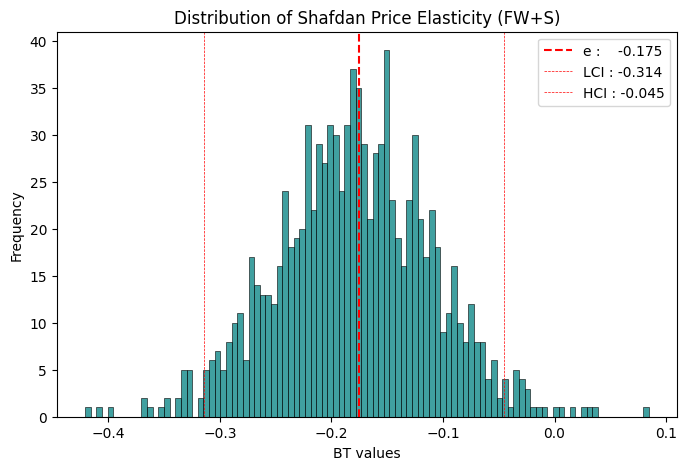

In [45]:
dist(my_direct_elas[0],direct_ps_elas, name = 'Shafdan Price Elasticity (FW+S)')